In [1]:
import hist
import dask
import awkward as ak
import hist.dask as hda
#import dask_awkward as dak
import numpy as np
from hist import Hist, axis, storage 



from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector as vec
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

from coffea.lumi_tools import LumiMask
from coffea.nanoevents import NanoAODSchema

GOLDEN_JSON = "Golden_data.json"

def as_plain_candidates(a):
    return ak.zip(
        {
            "pt": a.pt,
            "eta": a.eta,
            "phi": a.phi,
            "mass": a.mass,
            "charge": a.charge,
            "superclusterEta": a.superclusterEta,
        },
        depth_limit=1,  # no behavior
    )


class MyProcessor(processor.ProcessorABC):
    def __init__(self, golden_json=None, norm_weights=None):
        self._mask = LumiMask(golden_json) if golden_json else None
        self._norm_w = norm_weights or {}

    def process(self, events):
        dataset = events.metadata['dataset']
        is_data = (dataset == "data")
        all_e_pt = events.Electron_pt
        all_e_superclusterEta = events.Electron_superclusterEta

        # --- DATA-only lumi mask bookkeeping ---
        n0 = len(events.event)
        if is_data and (self._mask is not None):
            good = self._mask(events.run, events.luminosityBlock)
            n_keep = ak.count_nonzero(good)
            events = events[good]
        else:
            n_keep = ak.count_nonzero(ak.ones_like(events.event, dtype=bool))
        #print(events.fields)
        #event level cuts
        # apply trigger selection: `HLT_Ele115_CaloIdVT_GsfTrkIdT` OT `HLT_Photon200`
        # Electron.mvaNoIso_WP90 > 0 AND nElectron >= 2
        #event_check = events
        trigger_nelectron = (events.HLT_Ele115_CaloIdVT_GsfTrkIdT | events.HLT_Photon200) & (events.nElectron >= 2)
        events = events[trigger_nelectron]
        electrons = ak.zip(
            {
                "pt": events.Electron_pt,
                "eta": events.Electron_eta,
                "phi": events.Electron_phi,
                "mass": events.Electron_mass,
                "charge": events.Electron_charge,
                "dz": events.Electron_dz,
                "mvaNoIso_WP80": events.Electron_mvaNoIso_WP80,
                "mvaNoIso_WP90": events.Electron_mvaNoIso_WP90,
                "nElectron": events.nElectron,
                "superclusterEta": events.Electron_superclusterEta,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        cut_mva = (electrons.mvaNoIso_WP90 > 0) 
        ele2 = electrons[cut_mva]
        #check---------------------------------------
        ele2_check = ele2
        ###############################################
        #ECAL transition region: 1.44 < |η| < 1.57 that should be vetoed
        abs_sc_eta = np.abs(ele2.superclusterEta)
        eta_trasition_cut = (abs_sc_eta > 1.44) & (abs_sc_eta < 1.57)
        ele2 = ele2[~eta_trasition_cut]
        #check------------------------
        ele2_after_eta_trasition_cut_check = ele2
        #---------------------------
        ##########################################################
        #tag
        # pt > 120 GeV AND ak.abs(eta) < 2.5  AND Electron.dz < 0.1 (0.2) cm for Barrel (endcap).
        # barrel ( |eta supercluster| <= 1.479)
        # endcap ( |eta supercluster| > 1.479)
        # Tight MVA ID: Electron.mvaNoIso_WP80 > 0

        is_barrel = (np.abs(ele2.superclusterEta) <= 1.479)
        is_endcap = (np.abs(ele2.superclusterEta) > 1.479) 
        pt_tag_cut  = (ele2.pt > 120)
        abs_superclusterEta_tag_cut= (np.abs(ele2.superclusterEta) < 2.5)
        
        dz_tag_cut  = ak.where(is_barrel, ele2.dz < 0.10, ele2.dz < 0.20)
        tight_mva_cut = (ele2.mvaNoIso_WP80 > 0)
        
        tag_cut = pt_tag_cut & abs_superclusterEta_tag_cut & dz_tag_cut & tight_mva_cut
        e_tag = ele2[tag_cut]
        not_tag_e_tagcut = ele2[~tag_cut] # e not passing tagging condition

        #clean up all lists: only events with at least one tag electron remain
        has_tag = ak.num(e_tag) > 0
        e_tag = e_tag[has_tag]
        ele2 = ele2[has_tag]
        not_tag_e_tagcut = not_tag_e_tagcut[has_tag]
        events = events[has_tag] 
        #update list, so that for the new events list, each of them have tag e (at least one)
        #check-----------------------------------
        e_tag_check = e_tag
        not_tag_e_tagcut_check = not_tag_e_tagcut
        #-----------------------------------------
        
        ##########################################################
        #match trigger obj
        
        trig_e = ak.zip(
            {
                "pt": events.TrigObj_pt,
                "eta": events.TrigObj_eta,
                "phi": events.TrigObj_phi,
                "mass": ak.zeros_like(events.TrigObj_pt),
                "id": events.TrigObj_id,
                "filterBits": events.TrigObj_filterBits,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        #(events.TrigObj.id == 11) & ((events.TrigObj.filterBits & (1 << 12)) != 0 OR (events.TrigObj.filterBits & (1 << 14)) != 0)
        a = (trig_e.id == 11)
        b = (trig_e.filterBits & (1 << 12)) != 0
        c = (trig_e.filterBits & (1 << 14)) != 0
        trig_obj_cut= a & (b | c)
        trig_electrons = trig_e[trig_obj_cut]
        
        #check if the electron and trigger obj dR matches (if more than 1 tagged e find the one that matches with the trigger obj)
        # Build (electron info), (trigger obj) pairs for every event
        # next want to calculated the delta R between electron and trigger obj
        # when delta R is small, so they match, then this e should be the tag e

        pairs_e_trigObj = ak.cartesian(
            {"e_info": e_tag, "trig_obj": trig_electrons}, axis=1, nested=True
        )
        dR = pairs_e_trigObj.e_info.delta_r(pairs_e_trigObj.trig_obj)
        match_cut = ak.any(dR < 0.1, axis=2)
        e_tag_matched = e_tag[match_cut]
        not_tag_e_trigObj = e_tag[~match_cut] # e passes tagging condition but not trigObj
        
        keep_evt = ak.num(e_tag_matched) > 0
        events = events[keep_evt]
        e_tag_matched = e_tag_matched[keep_evt] 
        ele2 = ele2[keep_evt]
        e_tag = e_tag[keep_evt]
        #not_tag_e_tagcut = not_tag_e_tagcut[keep_evt]
        #not_tag_e_trigObj = not_tag_e_trigObj[keep_evt]
        #probe_cand = ak.concatenate([not_tag_e_tagcut, not_tag_e_trigObj], axis=1)
        probe_cand = not_tag_e_tagcut[keep_evt]

        # --- #tags per event (before Z mass window) ---
        ntags_per_event_before = ak.num(e_tag_matched, axis=1) 
        # ---------------------------------------------------------------
        
        #check----------------------------------
        e_tag_matched_check = e_tag_matched
        probe_cand_check = probe_cand
        #-----------------------------
        
        # update the event/electron list again, now only have events w/ tagged e
        # we have the tagged list and probe_cand list now
        ####################################################
        # now get probe e: pt > 10 GeV AND ak.abs(eta) < 2.5 
        probe_cut = (probe_cand.pt > 10) & (np.abs(probe_cand.superclusterEta) < 2.5)
        probe = probe_cand[probe_cut]
        #check----------------------------------
        probe_check = probe
        #-------------------------------
        ####################################################
        # build the tag-probe pair and test which is within the z mass window
        tp_pairs = ak.cartesian({"tag": e_tag_matched, "probe": probe}, axis=1, nested=True)
        p_mu_tot = tp_pairs.tag + tp_pairs.probe
        mass_constructed = p_mu_tot.mass
        z_win = (mass_constructed > 70.0) & (mass_constructed < 110.0)
        good_pairs = tp_pairs[z_win]
        ########################################################
        #the pairs are ready

        # check------- #tags per event (after Z mass window) ---
        n_probes_after  = ak.num(ak.flatten(good_pairs.tag, axis=2), axis=1)
        probes_per_tag_after = ak.num(good_pairs.tag, axis=2)
        n_tags_after = ak.sum(probes_per_tag_after > 0, axis=1)
        #---------------------------
                              
        #get different situations of charge
        q_tag   = good_pairs.tag.charge
        q_probe = good_pairs.probe.charge
        
        both_pos = (q_tag > 0) & (q_probe > 0)    
        both_neg = (q_tag < 0) & (q_probe < 0)    
        mixed    = ((q_tag > 0) & (q_probe < 0)) | ((q_tag < 0) & (q_probe > 0))  
        
        n_pp = ak.sum(both_pos)
        n_mm = ak.sum(both_neg)
        n_pm = ak.sum(mixed)
        
        tag=good_pairs.tag
        probe=good_pairs.probe

        
        #----------make histogram-----------------------
        tag_pt   = ak.to_numpy(ak.flatten(tag.pt,   axis=None))
        probe_pt = ak.to_numpy(ak.flatten(probe.pt, axis=None))
        
        tag_eta   = ak.to_numpy(ak.flatten(tag.superclusterEta,   axis=None))
        probe_eta = ak.to_numpy(ak.flatten(probe.superclusterEta, axis=None))
        
        q_tag   = ak.to_numpy(ak.flatten(tag.charge,   axis=None))
        q_probe = ak.to_numpy(ak.flatten(probe.charge, axis=None))

        
        w_norm = 1.0 if is_data else float(self._norm_w.get(dataset, 1.0))
        w_tag   = np.full_like(tag_pt,   w_norm, dtype=float)
        w_probe = np.full_like(probe_pt, w_norm, dtype=float)


        

        #pT and eta of tag and probe
        h_tag_pt    = Hist(axis.Regular(100, 0, 2000, name="pt"),  storage=storage.Weight())
        h_probe_pt  = Hist(axis.Regular(100, 0, 2000, name="pt"),  storage=storage.Weight())
        h_tag_eta   = Hist(axis.Regular(100, -3, 3,   name="eta"), storage=storage.Weight())
        h_probe_eta = Hist(axis.Regular(100, -3, 3,   name="eta"), storage=storage.Weight())

        h_tag_pt.fill(pt=tag_pt,       weight=w_tag)
        h_probe_pt.fill(pt=probe_pt,   weight=w_probe)
        h_tag_eta.fill(eta=tag_eta,    weight=w_tag)
        h_probe_eta.fill(eta=probe_eta, weight=w_probe)


        # fraction vs. pT/eta for probe

        m_pp = (q_tag > 0) & (q_probe > 0)
        m_mm = (q_tag < 0) & (q_probe < 0)
        m_pm = (q_tag * q_probe) < 0
        m_same = m_mm | m_pp

        h_pp_pt = Hist(axis.Regular(100, 0, 2000, name="pt"), storage=storage.Weight())
        h_same_pt = Hist(axis.Regular(100, 0, 2000, name="pt"), storage=storage.Weight())
        h_pm_pt = Hist(axis.Regular(100, 0, 2000, name="pt"), storage=storage.Weight())
        h_pp_eta = Hist(axis.Regular(100, -3, 3,   name="eta"), storage=storage.Weight())
        h_same_eta = Hist(axis.Regular(100, -3, 3,   name="eta"), storage=storage.Weight())
        h_pm_eta = Hist(axis.Regular(100, -3, 3,   name="eta"), storage=storage.Weight())
        


        h_same_pt.fill(pt=probe_pt[m_same], weight=w_probe[m_same])
        h_pm_pt.fill(pt=probe_pt[m_pm],   weight=w_probe[m_pm])
        h_pp_pt.fill(pt=probe_pt[m_pp],   weight=w_probe[m_pp])
        
        h_same_eta.fill(eta=probe_eta[m_same], weight=w_probe[m_same])
        h_pm_eta.fill(eta=probe_eta[m_pm],   weight=w_probe[m_pm])
        h_pp_eta.fill(eta=probe_eta[m_pp],   weight=w_probe[m_pp])

        barrel = (np.abs(probe_eta) <= 1.479)
        endcap = (np.abs(probe_eta) > 1.479)

        h_same_pt_barrel = Hist(axis.Regular(100, 0, 2000, name="pt"),  storage=storage.Weight())
        h_tot_pt_barrel  = Hist(axis.Regular(100, 0, 2000, name="pt"),  storage=storage.Weight())
        h_same_pt_endcap = Hist(axis.Regular(100, 0, 2000, name="pt"),  storage=storage.Weight())
        h_tot_pt_endcap  = Hist(axis.Regular(100, 0, 2000, name="pt"),  storage=storage.Weight())
        h_pp_pt_barrel  = Hist(axis.Regular(100, 0, 2000, name="pt"),  storage=storage.Weight())
        h_pp_pt_endcap  = Hist(axis.Regular(100, 0, 2000, name="pt"),  storage=storage.Weight())
        
        mask_same_barrel = m_same & barrel
        mask_tot_barrel  = (m_same | m_pm) & barrel
        mask_same_endcap = m_same & endcap
        mask_tot_endcap  = (m_same | m_pm) & endcap
        mask_pp_barrel = m_pp & barrel
        mask_pp_endcap = m_pp & endcap

        h_same_pt_barrel.fill(pt=probe_pt[mask_same_barrel], weight=w_probe[mask_same_barrel])
        h_tot_pt_barrel .fill(pt=probe_pt[mask_tot_barrel],  weight=w_probe[mask_tot_barrel])
        h_same_pt_endcap.fill(pt=probe_pt[mask_same_endcap], weight=w_probe[mask_same_endcap])
        h_tot_pt_endcap .fill(pt=probe_pt[mask_tot_endcap],  weight=w_probe[mask_tot_endcap])        
        h_pp_pt_barrel.fill(pt=probe_pt[mask_pp_barrel],   weight=w_probe[mask_pp_barrel])
        h_pp_pt_endcap.fill(pt=probe_pt[mask_pp_endcap],   weight=w_probe[mask_pp_endcap])



        # for check hist
        def flat(a):
            return ak.to_numpy(ak.flatten(a, axis=None))
        ax_pt  = axis.Regular(100, 0, 2000, name="pt")
        ax_eta = axis.Regular(100, -3, 3,   name="eta")
        
        def make_pt_eta_hists():
            return (
                Hist(ax_pt,  storage=storage.Weight()),
                Hist(ax_eta, storage=storage.Weight())
            )

        def fill_pt_eta(h_pt: Hist, h_eta: Hist, pts, etas, w_val):
            pts_flat  = flat(pts)
            etas_flat = flat(etas)
            w_arr_pt  = np.full_like(pts_flat,  w_val, dtype=float)
            h_pt.fill(pt=pts_flat, weight=w_arr_pt)
            w_arr_eta = np.full_like(etas_flat, w_val, dtype=float)
            h_eta.fill(eta=etas_flat, weight=w_arr_eta)


        h_event_check_pt, h_event_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_event_check_pt, h_event_check_eta, all_e_pt, all_e_superclusterEta, w_norm)

        h_ele2_check_pt, h_ele2_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_ele2_check_pt, h_ele2_check_eta, ele2_check.pt, ele2_check.superclusterEta, w_norm)

        h_e_tag_check_pt, h_e_tag_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_e_tag_check_pt, h_e_tag_check_eta, e_tag_check.pt, e_tag_check.superclusterEta, w_norm)

        h_not_tag_e_tagcut_check_pt, h_not_tag_e_tagcut_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_not_tag_e_tagcut_check_pt, h_not_tag_e_tagcut_check_eta, not_tag_e_tagcut_check.pt, not_tag_e_tagcut_check.superclusterEta, w_norm)

        h_e_tag_matched_check_pt, h_e_tag_matched_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_e_tag_matched_check_pt, h_e_tag_matched_check_eta, e_tag_matched_check.pt, e_tag_matched_check.superclusterEta, w_norm)

        h_probe_cand_check_pt, h_probe_cand_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_probe_cand_check_pt, h_probe_cand_check_eta, probe_cand_check.pt, probe_cand_check.superclusterEta, w_norm)

        h_probe_check_pt, h_probe_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_probe_check_pt, h_probe_check_eta, probe_check.pt, probe_check.superclusterEta, w_norm)

        h_ele2_after_eta_trasition_cut_check_pt, h_ele2_after_eta_trasition_cut_check_eta = make_pt_eta_hists()
        fill_pt_eta(h_ele2_after_eta_trasition_cut_check_pt, h_ele2_after_eta_trasition_cut_check_eta, ele2_after_eta_trasition_cut_check.pt, ele2_after_eta_trasition_cut_check.superclusterEta, w_norm)







        return {
            dataset: {
                "num_pp": [n_pp],  
                "num_mm": [n_mm],  
                "num_pm": [n_pm],
                "h_event_check_pt": [h_event_check_pt], 
                "h_event_check_eta": [h_event_check_eta],
                "h_ele2_check_pt": [h_ele2_check_pt], 
                "h_ele2_check_eta": [h_ele2_check_eta],
                "h_e_tag_check_pt": [h_e_tag_check_pt], 
                "h_e_tag_check_eta": [h_e_tag_check_eta],
                "h_not_tag_e_tagcut_check_pt": [h_not_tag_e_tagcut_check_pt], 
                "h_not_tag_e_tagcut_check_eta": [h_not_tag_e_tagcut_check_eta],
                "h_e_tag_matched_check_pt": [h_e_tag_matched_check_pt], 
                "h_e_tag_matched_check_eta": [h_e_tag_matched_check_eta],
                "h_probe_cand_check_pt": [h_probe_cand_check_pt], 
                "h_probe_cand_check_eta": [h_probe_cand_check_eta],
                "h_probe_check_pt": [h_probe_check_pt], 
                "h_probe_check_eta": [h_probe_check_eta],
                "h_ele2_after_eta_trasition_cut_check_pt": [h_ele2_after_eta_trasition_cut_check_pt], 
                "h_ele2_after_eta_trasition_cut_check_eta": [h_ele2_after_eta_trasition_cut_check_eta],
                "n0": [n0],             
                "n_keep": [n_keep],
                #------------tags/probes per event check
                #"ntags_per_event_before": [ntags_per_event_before],
                #"n_probes_after":  [n_probes_after],
                #"n_tags_after": [n_tags_after],
                
                "h_tag_pt" : [h_tag_pt],   
                "h_probe_pt" : [h_probe_pt], 
                "h_tag_eta" : [h_tag_eta], 
                "h_probe_eta" : [h_probe_eta],
                "h_pp_pt" : [h_pp_pt], 
                "h_same_pt" : [h_same_pt],
                "h_pm_pt" : [h_pm_pt],  
                "h_pp_eta" : [h_pp_eta], 
                "h_same_eta" : [h_same_eta], 
                "h_pm_eta" : [h_pm_eta],
                "h_same_pt_barrel" : [h_same_pt_barrel], 
                "h_tot_pt_barrel" : [h_tot_pt_barrel], 
                "h_same_pt_endcap" : [h_same_pt_endcap],
                "h_tot_pt_endcap" : [h_tot_pt_endcap], 
                "h_pp_pt_barrel" : [h_pp_pt_barrel], 
                "h_pp_pt_endcap" : [h_pp_pt_endcap], 
            }
    }

    def postprocess(self, accumulator):
        def sum_int_list(lst):
            return int(np.sum(lst))
    
        def merge_hist_list(val):
            h = val[0].copy()
            for hi in val[1:]:
                h += hi
            return h

        scalar_keys = ["n0", "n_keep", "num_pp", "num_mm", "num_pm"]
        hist_keys = [
            "h_tag_pt", "h_probe_pt", "h_tag_eta", "h_probe_eta",
            "h_pp_pt", "h_same_pt", "h_pm_pt",
            "h_pp_eta", "h_same_eta", "h_pm_eta",
            "h_same_pt_barrel", "h_tot_pt_barrel",
            "h_same_pt_endcap", "h_tot_pt_endcap",
            "h_pp_pt_barrel", "h_pp_pt_endcap",
            
            "h_event_check_pt", "h_event_check_eta",
            "h_ele2_check_pt", "h_ele2_check_eta",
            "h_e_tag_check_pt", "h_e_tag_check_eta",
            "h_not_tag_e_tagcut_check_pt", "h_not_tag_e_tagcut_check_eta",
            "h_e_tag_matched_check_pt", "h_e_tag_matched_check_eta",
            "h_probe_cand_check_pt", "h_probe_cand_check_eta",
            "h_probe_check_pt", "h_probe_check_eta",
            "h_ele2_after_eta_trasition_cut_check_pt", "h_ele2_after_eta_trasition_cut_check_eta",

        ]
    
        out = {}
    
        for ds, d in accumulator.items():
            ds_out = {}
            for k in scalar_keys:
                if k in d:
                    ds_out[k] = sum_int_list(d[k])
    
            for k in hist_keys:
                if k in d:
                    merged = merge_hist_list(d[k])
                    if merged is not None:
                        ds_out[k] = merged
    
            out[ds] = ds_out

        return out


In [2]:
m40to100 = 475.3
m100to200 = 45.42
m200to400 = 3.382
m400to600 = 0.1162
m600 = 0.01392


import uproot, numpy as np

bins_to_files = {
    "40-100": [
        "root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-40to100_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v3/100000/18197ca8-14a7-4705-acc3-5fbea17f890d.root",
        "root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-40to100_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v3/100000/185ba806-afd7-4a8b-9235-6e197fd618fc.root",
        "root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-40to100_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v3/100000/18bc8d9e-aaf7-45db-918f-8a5f93af48c7.root",
    ],
    "100-200": [
        "root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-100to200_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/100000/29f004ec-99e8-41e6-b02e-39b07294ab06.root",
    ],
    "200-400": [
        "root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-200to400_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/100000/aaac973d-7645-471e-85de-72ebf34015f0.root",
    ],
    "400-600": [
        "root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-400to600_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/2810000/94f7ccff-b6b5-4036-a599-a8e1b2307afb.root",
        "root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-400to600_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/2810000/a1eb4ac9-17ea-4119-9a67-16c030de773c.root",
    ],
    "600": [
        "root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-600_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/100000/42992f08-f719-4c8f-8d98-7f9588942ca8.root",
        "root://xcache//store/mc/RunIII2024Summer24NanoAODv15/DYto2L-2Jets_Bin-1J-MLL-50-PTLL-600_TuneCP5_13p6TeV_amcatnloFXFX-pythia8/NANOAODSIM/150X_mcRun3_2024_realistic_v2-v2/2520000/8e732505-eeea-45fa-b946-4147fdd1cc35.root",
    ],
}

def runs_count(files):
    total = 0
    for fp in files:
        with uproot.open(fp) as f:
            runs = f["Runs"]
            total += runs["genEventCount"].array(library="np").sum()
    return int(total)

Lumi = 109.08 * 1000.0

n_M40to100  = runs_count(bins_to_files["40-100"])
n_M100to200 = runs_count(bins_to_files["100-200"])
n_M200to400 = runs_count(bins_to_files["200-400"])
n_M400to600 = runs_count(bins_to_files["400-600"])
n_M600 = runs_count(bins_to_files["600"])

W_M40to100 = (m40to100 * Lumi) / n_M40to100
W_M100to200 = (m100to200 * Lumi) / n_M100to200
W_M200to400 = (m200to400 * Lumi) / n_M200to400
W_M400to600 = (m400to600 * Lumi) / n_M400to600
W_M600 = (m600 * Lumi) / n_M600

print(n_M40to100)
print(n_M100to200)
print(n_M200to400)
print(n_M400to600)
print(n_M600)
W = {
    "DY_40_100":  W_M40to100,
    "DY_100_200": W_M100to200,
    "DY_200_400": W_M200to400,
    "DY_400_600": W_M400to600,
    "DY_600":     W_M600,
}


768721
940431
808925
908938
843664


In [3]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

fileset = {
    "DY_40_100":  {"files": {fp: "Events" for fp in bins_to_files["40-100"]}},
    "DY_100_200": {"files": {fp: "Events" for fp in bins_to_files["100-200"]}},
    "DY_200_400": {"files": {fp: "Events" for fp in bins_to_files["200-400"]}},
    "DY_400_600": {"files": {fp: "Events" for fp in bins_to_files["400-600"]}},
    "DY_600":     {"files": {fp: "Events" for fp in bins_to_files["600"]}},
    "data": {
        "files": {
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/012eaa90-41ee-446b-a0f3-0f13b1e279d4.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/018cd773-9dae-4681-9331-939ae0360e0c.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/04353d0c-ad0d-441d-8db6-a38420dd3a71.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/047ea789-51e9-46a4-843e-7aae58cb51c9.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/06eaf7c4-f21e-45b8-8bd5-c8cb7bf05eae.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/08a87732-2813-4617-b305-d15aa89313dc.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/08b833a5-3764-4da6-8320-e9e5d81ad2ba.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/0b93e42b-a62e-4093-bc74-522a97b2b235.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/0d27061e-f2c4-4c4d-b9ca-08034bca0490.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/0d92b2f1-9031-4591-86ae-45e95138d436.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/0ea9d137-856c-48f2-934f-c102c4f79eb5.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/11688c17-2633-4494-862b-76d734b2ea9c.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/127ffb5f-164f-46e1-af64-79e1efeceb7c.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/12f2bee4-7f6a-4a81-8e64-fa2248aa7d4d.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/135b3982-03ea-4877-92dd-56261fa80dd3.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/1385920e-f9ad-43e2-8461-620462ff17aa.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/13a2e694-04f4-4ca6-a6fb-19c4db76a86a.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/140d75b1-8ab2-42b8-be8d-0db69df861b4.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/1704606a-c3a8-4d93-8124-4e668a8f7ed7.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/1824baeb-2871-41ad-9c4b-6823b08fcd6c.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/195fe329-ff08-40e9-bc72-2b70fff0cb3a.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/1f446edc-38b5-4f89-a75e-0ca2a5d0763a.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/224fcc72-93ba-4ae9-8358-24426d313fc6.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/24120c75-df67-4036-8918-5f1aad75cf57.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/241251d6-ff75-4962-aafb-2f25d2eb4c6b.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/242f63a7-28df-4ab4-84ce-c05ef3542e59.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/254727db-0ff3-47be-9a29-21804141c93d.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2564db69-592e-4ed4-95bd-8b9f0142b40d.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2646e247-440a-44ba-979b-06678602257f.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2708dd38-6df0-4ac5-ba66-649a49293ee1.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2720c480-25c9-4ec4-b3a2-05ceb7398ebc.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/29529760-5440-4770-b168-52f815eefb58.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2b2e0907-1329-454f-bd79-fb7c2df14ff8.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2ba7577e-f26a-4031-8a40-f5808187206d.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2be738a7-47de-470a-8fb4-8d0323ee9206.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2c02a8f3-0836-4fb9-88b5-e8f60f664982.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2d1f8dd7-db1c-41ed-b37a-cda9103691a3.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/2dc6a801-6be2-45ac-b9b1-d63d2d08302b.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/3151ab41-a5bd-48f1-be40-449b760a60e6.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/32861731-7f87-4ea0-9fc9-60f4ff08a42f.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/330d800b-b0ee-4122-a7d7-2bea1672ff25.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/33663d29-a0c3-45b6-bed4-a6966c232d11.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/38450ca7-123e-4210-8219-d4b44da88703.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/3b7dbae1-733c-4b51-9677-491f25da7da4.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/3c74a70a-0a8f-4de9-8448-0ae8a277da15.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/3d830fc0-269f-44b2-b2bb-740b0bb16c41.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/3da7c2f8-1b7c-409d-944b-37b0d011cdba.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/3db1b285-a2ec-4d58-9a30-fcf9dc409ba2.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/4051b1d8-2b39-4ee7-a199-df4aa87c6a1d.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/41631b0a-f974-4046-b6a9-5f45bcfc0e28.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/42930ef7-b2f9-4aa0-99e4-f0e8194793ad.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/42a644f5-0862-4d3c-a770-e746991330d6.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/435e0151-8750-4e00-ad0b-dc096605c98b.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/467ccbbf-d5c0-400b-91e1-d9285fd1286a.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/49c97f85-236b-40d9-a3b9-fdf1fed7ecf0.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/4b52b55e-f3d8-41e9-8e5c-1478d0f61864.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/4f1772c1-f2ce-4ac9-ba78-56030aeabb87.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/4fde340d-2f08-4efe-95de-a8b3ca1fec6e.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/5026b672-07ee-4a55-9913-1639c26bf5c3.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/518bfc2d-07a7-4e92-a3ea-3ae6490ee8c8.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/51dd4995-76d9-488c-a925-fb9b4b20e848.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/530cce6d-98da-4cdb-8573-2d8fac180333.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/548880f8-c4a6-44aa-a779-9948fb61cf9c.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/56413f5c-851e-4cb4-aa42-2c0e3243a89e.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/56c7f487-3b13-4d74-8aff-a1ff1188cdf9.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/58edabe4-259d-4fda-b710-cce1c1a47633.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/5a59125a-83c3-485c-a505-8b02f9e20d01.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/5bad854a-1e58-4f2b-a261-7667b149b452.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/5c533ff4-74be-4cd3-8f0d-c046b1fd8a79.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/5d2a4f50-0911-40b8-961f-af84d102bf33.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/5d341af3-2799-46e8-aaf7-cb71c4f46226.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/66c6df2d-8d19-4cc7-a7fb-fbc8b0222aa7.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/67640105-8776-4446-9b71-b081063ef3f0.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/67f44537-cb29-4eb0-8649-02547a97e99e.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/6923030f-b53f-4085-b391-e679547f66f5.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/6931c7e9-e428-4def-b4fb-223fe6b79e20.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/69595878-c2af-4918-8ea1-305d02f2e80c.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/6cdac8f1-a654-403f-8e8b-249d3d164574.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/6f744a2b-6709-448e-8135-274cad2c505b.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/6fc3fe22-ae67-4f11-aa35-93e59a784688.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/702ced89-6d9b-443e-8649-093f35ee372e.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/70c267c0-36a7-432f-b247-5d877f243ad3.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/717379de-fd4b-4254-af48-037afa88e76e.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/75f38941-6b61-48f5-8bc1-65a6bf337900.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/787fcd02-7fc4-4595-8ea4-af047c891e15.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/791e30c4-da4d-4c9c-9065-03ffa3ec9bcc.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/795fee7f-16ee-4797-a01b-a259e132550e.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/79dd420d-8a5a-4f32-a6e2-d5eee9a2a775.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/7f2c50bf-160e-41e1-9640-1820ef4fb1bd.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/7f82ab0a-25a1-4d43-98d1-8857baedb75a.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/7fe333ea-f030-4f68-b30f-5788884981a9.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/80d9ece0-da71-460b-9a8e-76de2202d590.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/847ca1af-faf3-4ece-b887-8fe9d1dd776c.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/876e9d6c-f7ec-4fac-8bfd-2eec5483a4ef.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/877cae8c-bfd9-4db9-b25a-59a6673485b8.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/8837e9b2-8f07-49d6-8b44-b4397d0996df.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/8a6da675-4d5b-4250-a500-ae8900cc1f6e.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/8a796b92-bba1-4a27-8932-4a9409e2356f.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/8b68e46e-0951-43d4-bb4d-fcf82eb2b6fe.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/8ce5ef89-f47a-49be-8e4c-03eb76ff4749.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/8d107786-e70d-46a2-a40a-0bdfcfddd61e.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/95574212-a2fd-422b-b237-f903044a2476.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/956bb401-6917-40fb-b0bf-232f510a3585.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/96511aed-7922-460d-83b9-e5b2130a16ac.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/99daa5e7-f210-4d01-8eb5-8a0bf28ff294.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/9b16c2c7-da62-414e-aa21-bdcb3e3e5469.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/9bc51674-021e-46d7-bec7-2aa2f06f9fdc.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/9daad7a4-8474-4890-aed4-d9999eff0977.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/a0818ce0-b2cd-4ab2-ae95-801fd58c4fd7.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/a0e59a00-71ab-4626-8a79-d2e364c700d8.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/a632989c-3c13-4747-9110-7391bfe1c7ca.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/a6c10849-0210-47dd-ab64-de9346eff5a2.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/a801edea-355e-4c71-8323-4c867134d106.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/a90972cf-4f01-426b-8cc0-d1166f97709b.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/aa104c10-a84b-4378-a55a-9ad4239c3509.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/ab464528-2ca8-4a1c-980c-5c3129f50619.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/acf264de-aef7-41d4-ae35-947d40a2128c.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/afeeba3f-1839-48b3-b243-dea69b5e0a40.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/b06c7a2d-2a0a-4ab8-bebc-8c06e6ef99de.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/b145be16-8121-479f-b7b4-9ccae03f2d34.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/b4d63568-79bf-4efb-82c8-8d0bfbc72935.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/b61ecfdb-03e0-46fa-ad97-6e37661533f4.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/b6703128-dd81-475f-aa1e-d6ec3bc68f9d.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/bbb4bcb9-498e-4cfd-992b-ad4704d8c0f3.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/bf0923df-2d5a-499b-86a1-f491fdcca0c3.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/bf59e66c-e03d-4053-a825-b766a4d81b07.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/c01e79f4-166d-48f3-b7d2-6052eb8884cc.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/c4731a5d-732e-45bf-939b-49809b4c90c2.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/c66fd4ae-c206-4acb-ae8b-60835e4e7e9b.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/c687660f-4e0d-4d73-8b8f-1d40b16148b0.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/c7793d8a-4bd5-4ebd-9a27-40c58c16d7bf.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/cb180f09-40b5-4f4c-b48f-0bf849d63126.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/cd032af7-b8f3-4780-a552-d508f4822a16.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/cd763246-5800-4cf6-a2a6-7c9e3ba7a8ca.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/ce2d5a9e-1d9f-4f23-9101-a8744a98f39e.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/ce8fb22b-cbd4-4819-a7c4-03e41f1de441.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/cfafd278-00ad-4f0c-b6f0-1fa4ccb94c8a.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/d0c383f8-da89-45d9-ad95-eef8f04ff2f5.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/d34e6e41-d975-4788-ade5-3eda6fb35de7.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/d4108d71-7714-4994-b668-40b6eb00b7ab.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/d499dd2f-1da3-42e1-87b9-bdd7c9f8955e.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/d8d37a00-151a-44e1-b957-24b6d3bd0b02.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/dbc5ec39-1c8e-4797-b090-ddc7d5ef0eeb.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/dbf7cd4e-5076-42c3-9526-df0c17f25c98.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/dd1745a2-996d-46ef-8842-727e9645ae4e.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/dfc6e6e8-19fb-4e80-86cc-71753e26d4f5.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/dfff95aa-2155-4d3a-b273-729701c13da7.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/e18b2533-bc9d-455e-aa3d-95aaf63f7408.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/e1f710c0-a437-4a0b-8d4d-14fb858b9bfb.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/e2553bd2-a58a-40a3-8dab-51c0712b087c.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/e2a02841-8e10-4483-adca-a1c09330b33c.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/e57a9e1e-72e3-4599-8137-dcf2be4eb909.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/e710851f-36d7-4d79-a527-ebb07b9b6b36.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/e72b8e61-5593-4536-99ac-acfc109bb806.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/ea08eea7-d295-41aa-8645-22d89f7384f0.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/eb3c2802-782e-4db5-98ce-e9a9c7eb03a6.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/ed1f381a-e8a7-438d-9c46-e080fd3afcc3.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/ee2601b6-9100-4673-8791-5b2919418c9a.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/ef2b5569-16a1-4d7b-ba57-dcb20d45a3cd.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/f30bb1c1-1b0c-4e1a-b276-8d4debb0e72b.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/f7c3238b-a310-4045-8afa-8c1962f2f7ec.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/f7e9f70e-d1fd-4cc4-8cf0-52a3f2d893c8.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/f86e9f3e-76ba-4fe6-814a-d4c52fd577cd.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/f9f840ba-7dff-4531-a6e5-49d8e65a15a4.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/fb572163-f7d3-473c-b958-040efee63849.root": "Events",
          "root://xcache//store/data/Run2024C/EGamma0/NANOAOD/MINIv6NANOv15-v1/2540000/fe89c8a5-437c-4e5e-a885-b1ff15077363.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/00e767fc-46eb-4ed4-9d8f-0d026e2339f8.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/02eed90a-3b26-478c-8374-75e6b503750f.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/04afc808-e994-4a7f-afa5-79e30fb2485f.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/07c26df5-93ed-4c30-af21-81d2a07512bd.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/07ce10ec-e87a-448d-81a6-078d2747fcd3.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0aea5ec2-7858-4a0e-a8f2-9355064d7f88.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0c2488c6-8079-4cd1-8c17-34debec6e146.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0d3a709c-bd79-4889-a571-7e65cc5880b2.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0ed67a9a-d0aa-4149-8f14-48cc39c42910.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0f27c28a-82b1-4e96-b928-f93fd5876ab6.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/105dc6e8-8bc3-4e7a-aae5-7f90569b8c0c.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/10a92204-a744-4d8d-8947-431848fc376d.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/10ba2f12-8ce2-48bf-8255-c811234c7aa0.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1141de70-ad38-4436-987a-759bb50a34e2.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/121e81f6-b8f7-494c-b9f6-6d613399cbe7.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1302d37c-dd19-4a02-8b67-b588f3ab777e.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/17ddce97-e87e-4094-966d-54eb6a8e8f0d.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1ab2143f-bd01-41e5-affc-2dc297a6c5e2.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1c387ba5-4a89-436c-ad42-4baa21f23dcd.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1dd6ff3c-2aa2-4f2a-8e92-b3882f6dd3d7.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/219e0306-afc7-4517-8363-61a40ae4a3a8.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/21ad0c9e-a8d2-4a5a-bcfa-074d812af703.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/235af39c-1ee5-44e5-84fa-a40eff6bb40a.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/276588b2-ac8b-498c-9fcd-56e1dc810c6e.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/2ac62774-e7c2-4a79-b51d-54ff75e0d251.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/2ca77074-e29c-48ac-8451-b2a7d9e9ae2b.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/2d8770d8-9bdd-47be-b0ba-a101e4d3c93f.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/2e1e1a84-1897-4b7d-835f-8b7e9b318d92.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/2f2b8038-a5e4-4a29-ad0d-5709fbf17746.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3062b3a9-16f6-463b-b892-e5b0a1a1c503.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3185b7d9-101e-4a05-9d22-8667c090366d.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/322eaadc-0952-463f-9b2f-85ecd26a2220.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/32f179cc-80bd-4b4b-ae9e-9acf8e2ab74e.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/34fc45ad-2225-4391-ae28-b0da224c7020.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/36327cbd-536b-453e-9089-a60e38cde9ed.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/37291b52-4868-4579-8c63-ba851b12ba3a.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3abf83ac-38bb-436a-9c7a-9e1998bcc9c7.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3c03f49e-5251-4dae-b309-895e252adccf.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3ce1ea31-b831-429c-8e6d-d2b5467035fd.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3ed136de-98ad-4606-8ff7-4f191d844b8d.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/409a2268-bcbf-4efe-ab4a-aa17b6a64741.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/452fbee0-3e9f-4c9d-aa5e-f34d86d75c41.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/467a90a5-2729-4ca8-bfc6-255d0da40205.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/4a68c1fb-cf40-449b-b95d-eb37e0f42c5e.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/4c768baf-109b-4ef0-b71b-b9a7d4ecd317.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/4efb6c0a-f9dd-4bf4-a6e3-0df6bc144c29.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/4fd5cc07-2ea0-4c48-b1fc-a9f41653f2d5.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/50943b43-939d-4753-953b-b697631bb037.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/54c1c6b8-205f-4614-8ba7-f56ffca9e778.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/552a88ac-5c7a-4f8b-897c-2c150929c8e0.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/56d52aea-af61-4fbd-a742-53693d25adef.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5819fdd4-9b9a-4e0f-96e1-c453be2264ac.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5abbfef0-6e3e-49e4-9406-56c89d3c0b65.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5adfc563-1610-4fff-aa87-2dac841e5563.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5cccb71d-279f-44d1-8aae-400aea4c917c.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5db4ce94-bbb9-4bea-981b-85178eff3d59.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5f0835bc-1f17-4890-ac82-46a59c59c2e7.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5f5cc627-93b3-47c1-8b45-28e717d476ba.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5f90c830-d580-4b3a-bd16-ec20fc866072.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/619c5ccd-fc59-49f0-9785-62f02545b692.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/646dea3d-a3ce-4bd9-804f-dcbdea663469.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/672e4346-e01b-4254-8106-55b2bf259a7f.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6ab5d154-38b7-43f6-add1-a27ec1756887.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6b38b162-ead7-4cdf-99fc-6670fb342c57.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6c097143-8abc-427c-9383-f68d18039cc4.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6cb29fd5-d774-4291-b87b-50a38c75ba50.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6e753ded-df33-4894-baa2-5686f6f9d5d2.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6eb22769-3cba-4926-b959-7171263d6b54.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/70995da5-c903-42cd-9cfe-7e8eeaa8c942.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/70da9382-b23d-401a-a051-63fd0eba3ac1.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/71911883-6608-4261-87f6-045437192d12.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/725d49ca-a46a-4aca-aa21-143bcbcc3d9d.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/72629c5f-5479-4a7d-93a7-1c89faf1c2c5.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/74c5ba05-afc0-4080-a504-95f2d331312e.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/75777e7f-1e17-4c9b-a3ea-dce1c12a0ce8.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7607b0aa-1a48-483e-85e7-ef8abcd63c09.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/761fe849-46a6-47d6-9819-32536b5a223d.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/77648e6e-9e5d-405d-ac7c-9ce2e7f09c28.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/77fc58f9-ee71-4b69-9575-db168bd7bc02.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/78a7d461-495f-4d4c-9532-008e4a94bd9d.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7a51b168-1ff3-4ec6-9e69-893ee1ae6797.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7b8c93ac-1382-4aca-9b8e-db1033d80902.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7bf87a19-281b-4ea1-9c7d-1df626a27cf7.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7c0cb1c8-c87d-4484-94aa-07ce36059908.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7f6c9b21-3633-42f0-9fac-39d472dab4f2.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/80ca4a09-6ecf-473e-9898-64711c0f4f59.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/83808c03-17bf-4d5d-8c20-8f56add66c0d.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/86e9909b-4461-4190-a16b-2b6f2c6e5200.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/874d7ee9-87e4-4536-aa12-49ec315a8224.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8a58eb06-d804-4748-8c66-395235042e58.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8cca1398-c150-4778-8098-5abae4a2cc34.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8db52e0a-8520-4f7f-a938-a2cff1eb64d4.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8f048c6e-dda9-4fdf-9078-ef9c7ea07216.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/91279202-2d38-4a12-8d31-01c5109c4baf.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/973eaa64-3581-4bd8-af96-548bf92c82a3.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/98e96ef4-cb6c-4024-8108-b1d65345e02c.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9d4e97c7-f23a-4cff-ac72-58488e544076.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9d50411f-e876-4eed-9c36-4369dec546db.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9f298a99-1aa2-46d1-9c8f-067e3af9e475.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9f3b3aea-53a4-48cd-ab5f-44aae44e3bcf.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a24da425-17a3-45af-a952-2d949fa5ac07.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a48fc81b-f493-4d01-9768-fdc960c34c36.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a51def25-1a55-4ad1-b386-dcdd71068cc5.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a731e5bd-4d23-4446-b1e8-ca83dc4e1f3d.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a8ffd28a-4e82-4618-99ca-8cc9e6e3c361.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a974706f-198e-41a5-aaf8-4e0f023dfd3f.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a9e80689-a1d5-4da8-8d8c-bfda4dcdace0.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a9fc291e-b3aa-43ef-992e-7d6795218c4e.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ab087a1e-9bf7-4070-aab5-e38bbba4e3c4.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ab21cf17-9017-468a-b359-eb9d47e7c8da.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ae3758b7-0236-4846-8b3b-ec818ad7647e.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b1bf33d1-15a9-4a9e-a8b5-f0c2d16ba73a.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b1c241d9-7e37-43e5-a564-6805da26bf66.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b5e36e45-2683-441b-9804-1cd5f69d31b6.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b65a0bb0-8c8a-4f4b-bcd9-9bbdacbe0527.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b75d10c2-192b-4095-a1ce-04b5be1c1235.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b7bce0d5-27f3-48e2-820b-edc5df869cc7.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b806ee4a-8fd5-4ec1-98db-6c8e3d15e109.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b938f292-1097-4aa0-b2f8-1650cf637b5b.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b969aa83-1919-4ab7-aa8f-b6df505dc9b8.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b9808c5b-ef25-47ff-8384-2d71a8575629.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/baeacc43-d0cc-4a73-b2e1-49cfd9aff790.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/bdef4c04-fda3-4601-af97-09fbf10263bb.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c1985144-57a6-47aa-85c2-506a6a369d3c.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c1adf567-db18-4bfa-832c-898cc5d95ef5.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c1d69156-b838-4e42-8d28-94399d119c89.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c3235b73-21dd-4996-850b-9083a212eb9d.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c60e434a-5876-405f-8f8f-b670e4dee73d.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c68269f9-f3c1-444c-83a4-3ff72cda4d0d.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c701bf37-6a69-4002-be61-24ada3251906.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c7522f2d-2bc8-44d3-b999-5e7274a45502.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c785a7ce-d63d-4f47-9b49-4f0e664ce47f.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c887c048-2bcc-4f9e-bd80-2046fbcb3ef4.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cb31c05f-82b5-475c-9fed-8144e98984c4.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cb9549d6-01e4-4fc6-a5c8-71fad9f1653e.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cc7147a3-a062-44c9-b218-b0b37905cbd2.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cd21cf8c-a70f-4b1e-9483-fa54ec6455a9.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cdd6b2db-051c-4b66-91a6-b6434df1ed9b.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ce502ff8-768d-4d1d-95d7-b7f10d4d1651.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cea6523d-b9d4-4a82-a479-1d14df9d44a3.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cf8c050d-b223-4507-90c5-a8b2460b9955.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cf8f5b97-6347-4210-93a0-e5bf14a93b10.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cfc7d009-2fd2-4e71-b54a-28699f8934df.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/cfdfd2e5-37a7-4b8a-aba3-95a2b56d9923.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d193ebc2-6f89-40a5-8a65-6e86bb5026ad.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d2649481-d4b0-46cf-aade-1339926bc8c3.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d30cb053-73c6-4b3f-b3c3-eb6b3ea57d98.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d601a6ab-bfe7-4c36-9e23-e1664506df79.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d9f97116-c25e-4b2e-a141-32c7cc9c63bd.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/dcf6f664-3121-46e0-8215-2a4f83473d92.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/dfe397d5-2dce-4587-88ea-57cb70c4b465.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/e0504a01-067a-4cab-8f78-92120cab494c.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/e31d238d-62ea-43c6-a9ff-22a52dc900f9.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/e325ebff-bca8-4fc6-8e78-12e2213726c2.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/e32a58d5-5125-4bd5-8df8-f0be54e84456.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ee80dc1e-5b39-4e20-9117-6639c5222bb2.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ef4380e9-c32d-4146-9683-6c957f84c425.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/efab065a-5e79-40ea-8b9c-c6a06388e5bc.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f0fbc4e0-71ff-4eb9-9c6c-cc263036055f.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f535d868-2a27-4357-a140-669d0ddc7280.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f76546ac-ea6e-4e7a-9a48-e5dde4f19f4e.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f93e6fcc-acd6-4a7d-933f-591902c2aa0a.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f94a8181-536f-4606-8d22-99f0a23360f9.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f9acd322-363d-4328-a1ec-833d9ec6039c.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/fa8af595-ef36-42c3-a6aa-6358bbc12de4.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/fc5f6ab4-4e4a-4c0c-bc4b-67b1d0b00a86.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/fcf9195e-4022-4a7e-84f6-3c27d806744b.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/fd1c945e-c613-41ad-a988-585d86aea39a.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ff73b0ac-7d21-4d94-8c0d-02e4f83a1405.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/9992789f-aca9-4bb8-9f32-e6c93cf5d52d.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/9c332ffd-0fb0-4803-8d58-31f6181d0277.root": "Events",
          "root://xcache//store/data/Run2024D/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/e6234ccf-d8dd-4551-8b6e-3295701e7b14.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0d75742c-43d5-4dec-b188-dcf79d8275bd.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/0f3ef31a-d2cc-40f9-83e5-0c461b503f87.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/1b5dc750-fe3c-49c0-b7e7-3d10d2e18ad6.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/204579bd-be64-4e13-9dd7-fdcf5c97f76b.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/298d5b92-ae4c-4d6d-9e33-158b219ddd17.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/2f34d47e-df44-4e2b-b986-2b3895e70454.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/303f95fe-ab38-4ae4-a948-2d570e1d9a4e.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/33d44235-c59f-441b-a802-80cef1748e79.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/361a8800-5f6c-425e-a3f5-f918f2587717.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/3e234401-0963-4a46-8371-577fa830fc5c.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/40dffcef-7caf-47f9-bba2-42c0ba72802c.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/42a86896-55b6-4a30-92b9-c8aa77bbcaf6.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/499c844d-0fae-4ccf-b9cb-148fa404599b.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/538d285c-5209-44d2-acea-ea781dd6ac48.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5ebd8503-1892-4ac4-ac3a-136502727030.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/5eca7092-3deb-44db-bed9-6f9fbc40ae73.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/60d249af-5ee8-4641-a23f-7d79ce0155c4.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/61d14b9c-029f-4be0-9f3c-79636eac3de9.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/6f987a7f-696f-4b9d-a929-8a9c40f82c71.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/7a755d3f-d27e-4c3b-bac4-e04199ec5de2.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/80176d53-eae8-41ee-82ee-978f85000965.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8108b44a-5f0a-4cad-aac8-9fae3624e4c1.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/85109c3f-0613-4aa5-9dd0-b93546420904.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/853d89fb-e474-4e48-931f-f1fafbc218db.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/86a77637-6d93-4100-88b8-9cae4619cc72.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/87f7314a-371f-4d04-8baa-de66ea9cb886.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/8e324b25-93a2-42b0-8309-1d1170c1b05d.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/94d87159-cfdd-45a2-9e11-63f1fd6cae18.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/95c0c447-6c63-4a25-b8b1-1061431ca87a.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/97a2f785-1617-4d73-8ea9-605dd88401d5.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9873061e-834c-4a53-b221-d9cbc6093457.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9e3fa8a7-c3e6-440f-a21c-9ce3bdc3f509.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/9e908d30-e568-4ad3-b156-842a7934cddc.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a543ed70-ba80-4339-a8f1-abce1cc81091.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/a89ee3d8-ea63-4ffb-9909-d1706e8024e7.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/b2a9cae0-a032-423c-8140-19d77722a681.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/bb7be7a3-d8db-45c7-949f-d06b1d39f7df.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/bc876bfb-47e6-4b7b-bff9-18cd04a4b1b0.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c2678261-fcad-48c3-9c60-74e0c35318ae.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/c61f2d48-a485-45f1-8329-acf57469f813.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d1fd4cf7-b5dd-45b9-b5f1-1dc40b94f907.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/d713e739-d2cd-4215-b328-0dfc2b76207b.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/dff3968c-85b3-4781-85f7-01a5dbf2130f.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/e124c549-f187-4ce5-b75a-a9faef033039.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/eb3ec963-1637-4d5c-b5e6-154ea4d8767c.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/ed933e37-3388-48bf-9cc9-4106df049b69.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f2e92b9f-4677-4f1c-8be8-360cc6fef0be.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f2f4e250-ac07-46c5-bbfa-ab470947501d.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/f850d485-e211-42d0-9ea9-a87c323195f5.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/110000/fe78e626-5a8a-4c26-bd18-0d92e6bc7b7e.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/00baf0f5-13bc-4588-8205-c19d7c448d00.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/01d6675d-30b4-4162-9f08-c5baa6644cb0.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/03b6e6cf-055d-45a6-bc70-8493ef3e8dcb.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/040b4324-0ca9-4ff0-a35a-c31d3b168849.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/05a84a3a-f23c-4eb6-ab47-35928dc5d639.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/07de4a50-e3d9-4a48-a54e-4d2a49459f72.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/08f28722-e9ac-414c-a08d-221e24a7d93c.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/091ad25d-7a2d-4600-b5f1-6c8572a5f383.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/09a4278f-668a-4712-b5aa-2482f307109f.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/0a31177c-7c91-485a-bcbe-415500a6a57e.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/0a5e0ca0-d06b-4c44-b94f-2b93b5b47140.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/0afc2fc4-c746-498b-9b10-63315da37f86.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/0cc611f3-1e1d-4d2d-a047-6aedc67ffca5.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/0e2b9ca0-3f43-4bc7-9836-9b598fb3c1ee.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/102ff671-4b21-4aa4-af22-c5b1aa365852.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/10f2f46e-7265-4124-a9b5-00a565d18e06.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/111e456e-fe82-44e8-87eb-e659469a6651.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/127fdc26-297e-4fa4-9bb8-eaadb3bed7a1.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/129d6b63-01c2-46e3-9bf3-8ea23893bac2.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/140e4279-4820-4913-9916-d4c2cdb49858.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1494197b-8492-4a87-8bd9-6dae923b3e0d.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1584f726-0853-4da3-9610-5f7dfc1c5fa4.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/16994ab8-7918-469a-aedf-f69455fc8752.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/17950b16-965a-46bb-b656-b76512176536.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/17e0d935-53cc-452d-a648-24fe392599a7.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/19720360-ab0c-45ea-84ab-843f4964dfbd.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/19f11514-4ffd-4364-8762-6c7cc26b9a15.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1ae490df-abce-46a1-b7b0-56d5553f5819.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1b23d505-c9a2-46ef-a7aa-616468b7dabd.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1bbb36d6-359d-4836-ba37-41f5fbd81c96.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1ca1a8e0-c674-41c5-b3cb-0231790fba50.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/1e7ab86c-f7f0-4916-9a97-c9c07b22a1c5.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/213bbb71-9537-49cc-9aa5-2d0b3b149c4a.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2306b023-4808-40c1-ac6b-aa1b78d6d9ca.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/234c1389-221b-4f8a-9b1e-e1f94e721438.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/252410d7-2418-4b7a-b58a-4af7a50e9ff5.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/25792fe2-acff-4f7d-9958-f740fbc7093e.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/259dd1e7-2040-4430-8e39-6ea9d67e1205.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/25e6bef6-13dc-4edf-9b76-af7d091caba9.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/263d6059-df6f-4d46-b97c-dd0602d80452.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/26a836de-547d-4eda-a733-fe6776271244.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/26bc52c6-3307-4521-8540-829d1996cf5c.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/281b8eb2-1e8c-4230-a3a2-ddb28cc40757.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/29c6faab-1f1a-41f2-8255-194983e082dc.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2a998390-96c5-40f0-a55b-6e5101806422.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2abd3384-3cc1-4600-b500-098d1dcf8880.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2bb7cf96-64d9-4635-83f3-0159388bf4f9.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2bd8eabd-786a-40e1-a59c-daa2f09e5d7c.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2e9065ec-aa82-458e-9f91-731db2711916.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2e9bb2fd-6083-4901-a32f-76a8d2a3c301.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/2f287225-b86d-430a-b2e6-cfa685015a89.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/316eae81-3f9e-478c-b007-ff368b7ed5cb.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3328c827-85bd-46ea-8749-13b12627b39e.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/36bc7beb-61fc-44f0-a80c-4aa59f58e1d0.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/38830c71-0b3c-4568-88fa-987b57f1085c.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/38c06291-9536-4ce1-8a48-b8919ada44fd.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3978b642-7570-4f83-83ea-fb5ea26123ee.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3a125cfe-8de6-4935-b659-267f52c86dc6.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3b2ec613-6a6f-4e3d-89a2-9a86c1c5c4d3.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/3f306275-8a9a-4c21-9b52-df7a499a7b98.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/40579739-9771-4c98-8e0e-a426ab18ccfe.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4060302a-4702-45da-bd64-07a0aefc516c.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/41a74d72-e758-4c89-b1e2-f1dacad2b0a5.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4231e06a-ae0b-4672-991e-3948b455145f.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4291a148-03c9-4ee3-80f5-8b6a9b0011f0.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/43f0f0bc-52d1-4cd0-acf5-003d4ac53507.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/43f185a1-743e-458f-a14c-7ce70d112a37.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/44e8842b-6c37-4b25-8cd0-b697475b783d.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/45094bde-ea46-4f8f-aca1-a561a798bd9f.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/45b498ee-e621-4def-b770-a074928dfbd9.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/45e25a78-031e-47f3-aead-a2c519588e92.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/46978876-c667-45e3-afd2-6c3d9586affa.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/46cd4cdc-06a4-40e6-b552-51c1b0621db4.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4a01196a-9bb3-4f83-a6f3-452a5e71f330.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/4d8b612c-64d8-477c-a347-663e549c7a13.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5152be25-cc9d-43ff-8d2a-9e220b3282fe.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/51698a35-9358-42fd-a2a4-0c4b7e7f578f.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/520da95f-51b6-4ad7-bad7-7952751c7a36.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/52f23fea-efbf-4db4-bc05-a125c90ea693.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/53200862-3fb9-46c6-abc3-0f13acd4f968.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5487ee97-4f6e-40ab-82d2-1eb0a8108111.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/55f40975-546f-4eb1-a4a6-e704403e2972.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/56c64e50-e714-4df7-b659-b2ca9e1b18a4.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/572abc79-cd0d-4612-861d-c3d318a8c358.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/58966135-9005-4648-8b45-91180ec1dcb1.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/58a2ca58-6f50-4373-a3bd-b66feba37411.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/59535e91-ae92-4657-bc60-1074b0947b1a.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5b9efc0e-5745-412d-957d-c8909b0c8a2c.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5be8f53c-7936-4e90-ab80-e45611305b39.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5c31c2ce-b444-4d7d-8162-cfcf20debc3e.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5cb2577b-b413-420f-9345-708d4e350a33.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5cdb60fc-cb59-403c-9b39-a2df6eb4da5b.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/5d89359e-968a-4ce7-9455-bec0d8339c8a.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6056dbe4-54c1-48fd-8fff-9b309a2ef338.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6124cc4c-f9e0-4182-8e7b-7f04020fbff3.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/617b3577-5f47-4248-985f-539e00f2ffce.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/62b240ea-89e2-4015-87b3-8732bba0068e.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/640845c4-3acb-46cb-9154-d578735ee02b.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/640e6015-70e6-4d33-a66d-1afe98ed171b.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6648b3ef-221c-45d8-94bb-f08ed8d5a777.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6660a352-f52d-4636-b25a-eff7370936e0.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/66d38f7a-b309-4b9d-8008-b4dcb0bfe642.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/672c6cf3-1498-4bf8-9b23-9c412567c58b.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/693e8f64-755a-414b-a62d-11d6482a4298.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6a5d8337-02be-4980-b874-8f11b4bbc4af.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6f33871c-2435-4373-a415-f6126ec4ecbf.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/6f911878-b4e0-44d6-ba6b-d33f829875fe.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/7070189d-7322-4997-8061-6066350febc8.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/7204ec99-ad26-4bbc-b32b-d490ea733370.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/736edee0-16dd-4500-9879-3b355dcd010c.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/7495caa4-4a01-49d3-b7ff-a2151a9d7862.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/76e2af0d-1bc9-445b-b696-d7384c526711.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/787df470-0d67-4dfe-8e7c-8d57855b1fb0.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/789a84f1-d0a6-4dc1-93d0-72440da17129.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/81326abb-ba9d-4200-8b5f-0986760bed12.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/81c7b850-0695-48e0-8984-3ffe65c01d26.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8243c1a8-d44e-49ab-8ebb-308e3d788b52.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/836e689e-087c-4fc5-b5f5-15ec1d322789.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/83fde448-9ebb-47d8-bc90-fe35281fd788.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/845f589a-459b-4a01-9a3b-46d74e0a5c57.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/85305e0a-a752-4ed1-ac13-3d51d05b5acd.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8714b4ad-dc05-4350-a431-1c5ffac89aeb.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/88ad7b21-6ac3-4993-87bc-47c4581349b3.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/892ef454-8e7c-489c-be9b-2ed61683d40b.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8a4e297e-a8f7-40c7-9cfa-3fa218a56b88.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8ac5f384-4fcb-4766-87d6-99c1fb413eb2.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8e030e2a-1689-431d-9b2e-a245b592e22a.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/8f8a1870-74ed-48e9-bfbc-8faec13edaa6.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/921af155-44a3-4405-a0ae-e8c5fafd42ce.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/92cd7637-5fda-47ae-afb7-8afd02b046f5.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/948743c4-70af-40ab-9d7b-0954e7d98169.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/97afab80-84fd-4e49-a049-9423dc19a9a2.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/98d575ab-6135-4734-af45-63af5c385ab5.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/99266e9e-82f3-4e44-96ec-7ff9f30657d5.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/9d0ca4a1-98d2-49a6-9601-7beb99e7c23e.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/9fa0f08a-37d9-456e-a22e-ce9682a5be81.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a31eab8a-ada6-4bc5-b209-be722067bab0.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a4452c4d-3a0b-421a-81b6-4e12c48cc4a3.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a758d4b6-c977-41c8-af3f-da0aee0fd1fe.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a76791ef-86b3-4017-9f75-8ad96f24cf06.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a782f08c-7842-4b66-9d6a-a16557cf975a.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/a8b12c4b-5d2e-4c8e-b241-10dd7cf7be30.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/aab3cf85-2cbf-46e7-baa4-3a6bc6f03a26.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/aae9bbbe-f882-47ab-93c0-75492bec47a9.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/af6c7e1c-b084-46dc-9545-e8682fda88f2.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b01242fa-d364-4260-afb0-0399feb1a227.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b187232e-b1ff-4b05-b78c-53a18e935a1a.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b23d2e8f-b613-4c6f-be5c-1805ea1bfc30.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b5c5afe0-165e-4940-99e6-a72432e890c5.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b5d589d6-4f85-41c1-b432-db51ea936cea.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b6bfb7e7-f5e8-4c24-a242-36ea7edcb4d6.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/b8ec0f84-8aca-4890-b14d-0c5b89043ea4.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ba900a49-3bf5-4c71-8acc-e10510e38bbf.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/bb85815f-6058-4b87-9b5a-e17f3715f0cb.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/bbdd57d1-4fe5-4b89-9e36-b309aff30fc6.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/bce8d088-ebc0-4a03-aeec-ce4f6b0c4c18.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/bfa7d3bc-1cd1-4aee-9e3c-6f70d49c3b7e.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c04e02ea-9e27-4415-9db7-8e4874f44e16.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c2451779-e149-4e0b-9003-6b1f9c573816.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c3389b1d-6506-4223-9f7a-6036087626ad.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c36e81f4-a2af-4a15-98fe-b12e0bf3f6a1.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c441911b-77cc-49e9-bdb9-1e0881a1a109.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c4ec34a2-926c-4761-ae72-c4240c33f33a.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c6adca44-57b9-4854-8271-694e8a6770d0.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/c892c229-459b-4beb-8b50-ed651fc7b155.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/cac5e5ef-9563-4efe-9eef-4583af403053.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ce414069-b787-4243-aceb-0cbc03dfb156.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/cfc116c5-387f-458f-91d2-b73795a9bdf4.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d171b5fd-ac08-4d38-914c-a1ff888c6d1c.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d1c88457-8abf-4f4d-834b-28749c1615ad.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d301c5ce-8ebf-4a0f-b806-4e60be38183c.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d40c60b5-51c7-4158-b321-c25a11e6b829.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d59cf1c2-d201-4f89-b5b6-86991bcd237d.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d5e1b66e-27c1-4838-8de8-a038050796b4.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d855a9b4-523e-4de9-a1d5-c1c2cfc67821.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/d991a06c-25ec-424a-a7c9-09f605f146f1.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/da658d9f-fc3b-4933-907b-18ac8e0f3ce4.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/dacb2962-f2d5-468d-8c43-81dbeca8814f.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/dbe92c84-4256-424a-8efc-5d592398f541.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/dbea6a21-c240-47f7-b428-ca415fa4f84a.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/dc579226-7ab8-4a05-95e3-81e9603fdfdb.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/dd585ec2-debe-4c9d-99f1-5283a0596a28.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e05d1616-966b-4fe0-b648-f10b05953df8.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e2804575-6100-4983-bbf4-fd1244223109.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e36694b9-5307-4f3a-99c8-4b99fb619c8c.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e3adc64f-f5f0-4cec-8922-22da3d0c8b2c.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e3c33a06-4318-4bac-b27d-eb15e57d2176.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e3e06c9c-eb9c-43e3-89cf-e38c6a7bb4f3.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e53e9a37-76e4-4951-960b-35d30e894e05.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e57553dd-8e29-41ec-acdd-566724ec6c1f.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/e6899429-d83c-43b3-9687-ebae722caa78.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ea8ca152-c276-4b83-b4c3-39486d385a0e.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ed0259e3-6a99-4539-ab8b-faa26b95cf90.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/edacb0db-05e9-4ead-bd07-011b5df61851.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ee84dd1d-59f2-49c8-90ca-67d54adee72a.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/eebd8f92-70a3-4ffb-b3ed-879dfda77b6a.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ef22b653-d8b4-4030-bcec-7988436a91e2.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/ef903c88-6e0f-4d70-9374-eca8ffe246ee.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/eff7bc7f-70e0-4aab-9151-eb4e452dedcc.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f05c9796-0402-4505-910f-81e1cdf680ae.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f16e4c20-e4d4-4f2e-9238-d8ae13c900c4.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f2b2496e-f95c-4434-8e0a-8f19195e606a.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f3c23576-9e29-404f-a3f0-70a8b71f4a39.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f4ab2b25-7c68-4e94-943d-3e811b1d3dfe.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f5654724-39fb-47b6-8125-ba3c37d02725.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f6394040-5f3b-4eee-b585-6e78769244f8.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f6415bca-4131-40e5-a31b-af7f0ba23568.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f6dcdbdb-2705-4e7a-8923-1fa2ddcccd70.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f6fbd67f-2f4a-4c61-ba94-5909e8f73b7e.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f7227f33-8ee4-4b5b-a17b-b6d4ed7996d3.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f792b14d-d930-4d1f-a696-8fe2077480b8.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/120000/f897828b-59ce-4413-930c-346e6c22af01.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/2520000/4209002b-d832-4263-9a94-028879139287.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/2520000/fb8b671b-3676-4d79-a614-6a54571aeaa8.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/4636f415-555d-46dc-80b2-e9e70985ba7e.root": "Events",
          "root://xcache//store/data/Run2024E/EGamma0/NANOAOD/MINIv6NANOv15-v1/2530000/7d79760e-cb10-447d-8d63-b729dddf3ce6.root": "Events",
          }

    }

}

from dask.distributed import Client
client = Client("tls://192.168.202.19:8786")

runner = processor.Runner(
    executor=processor.DaskExecutor(client=client, compression=None),
    schema=BaseSchema,
)

proc = MyProcessor(golden_json=GOLDEN_JSON, norm_weights=W)

proc_out = runner(fileset, processor_instance=proc)

out = proc.postprocess(proc_out)


ds_data = out["data"]
ds_mc_40_100 = out["DY_40_100"]
ds_mc_100_200 = out["DY_100_200"]
ds_mc_200_400 = out["DY_200_400"]
ds_mc_400_600 = out["DY_400_600"]
ds_mc_600 = out["DY_600"]

Output()

Output()

<>:97: SyntaxWarning: invalid escape sequence '\e'
<>:97: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_27010/2417028480.py:97: SyntaxWarning: invalid escape sequence '\e'
  title=f"{nice}: $\eta$ (Data vs MC)",
/tmp/ipykernel_27010/2417028480.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


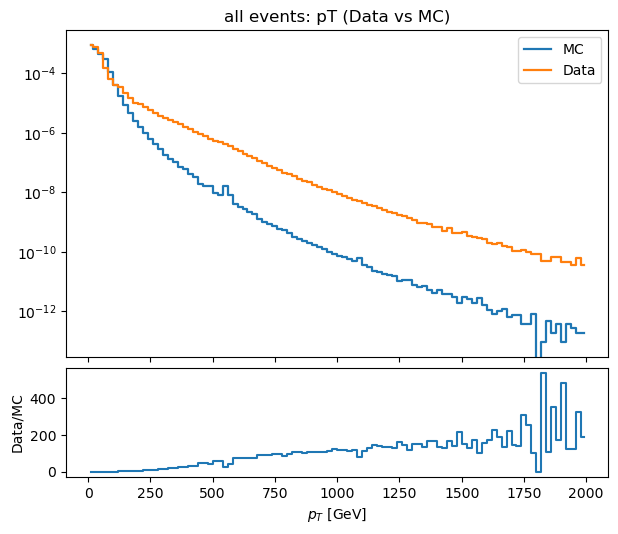

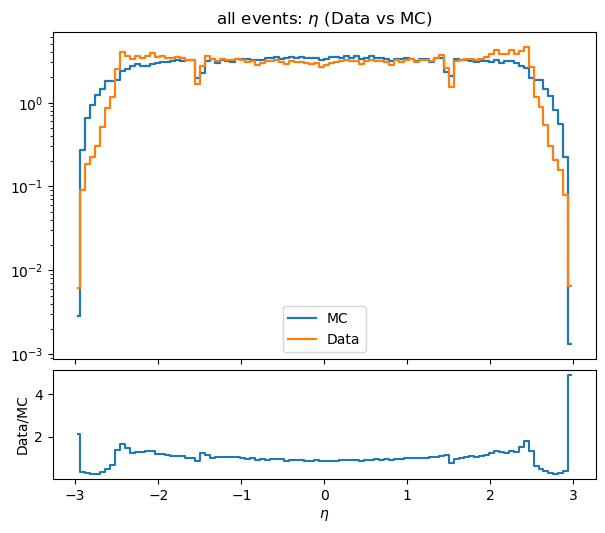

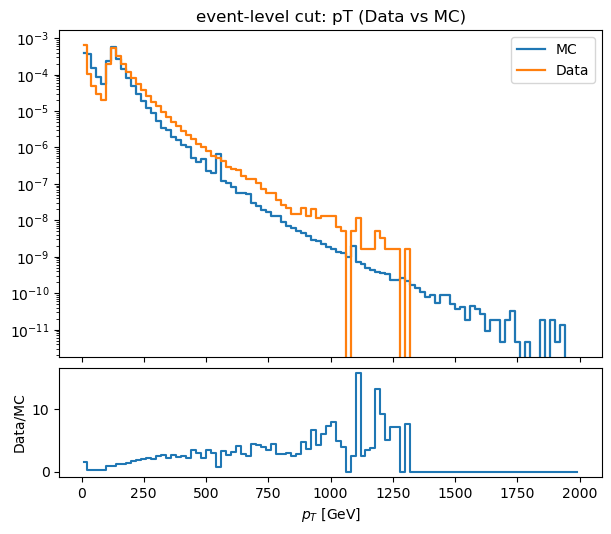

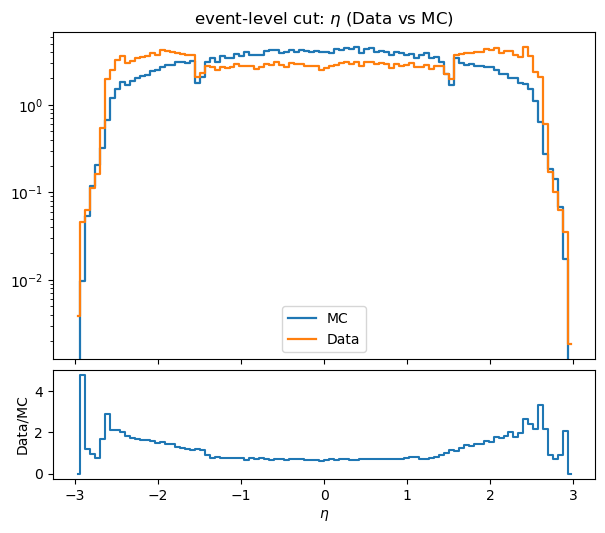

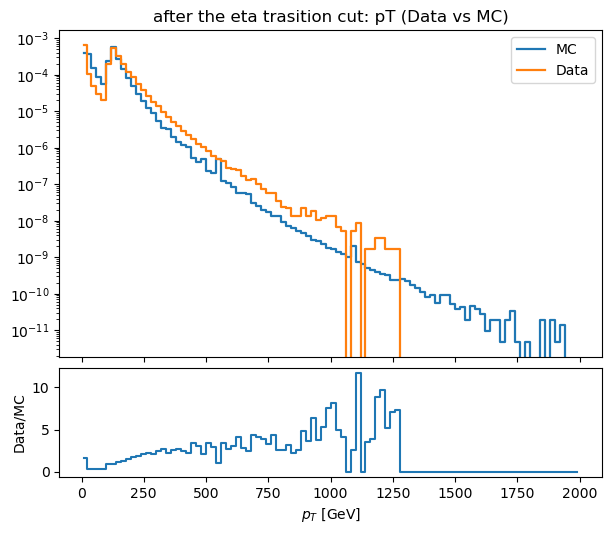

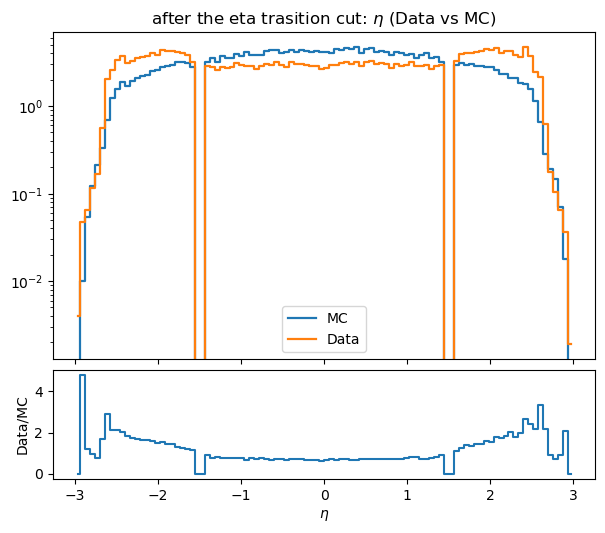

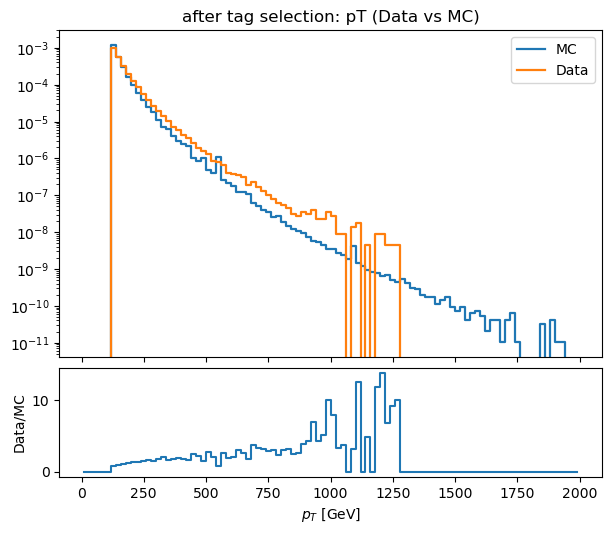

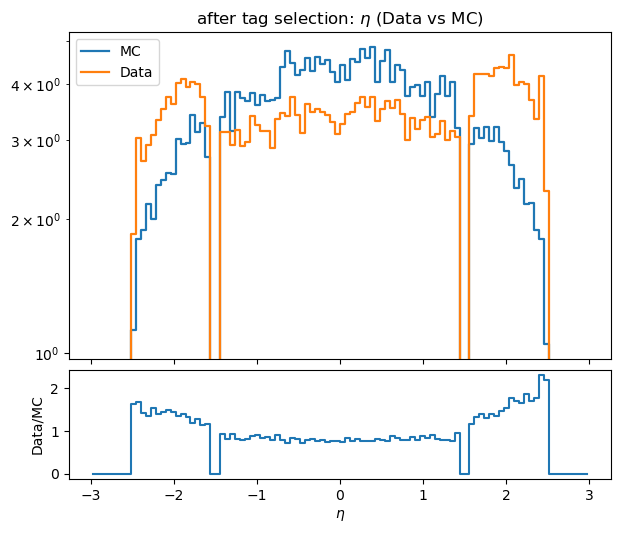

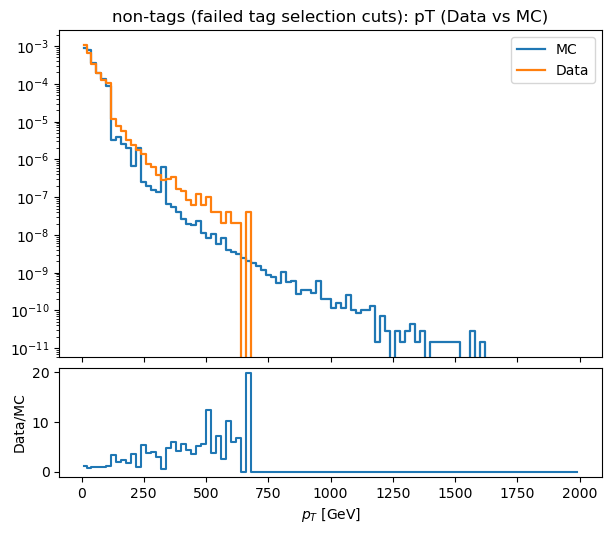

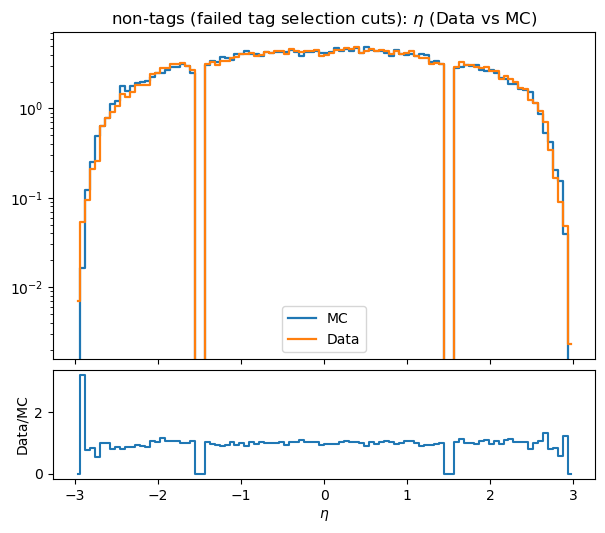

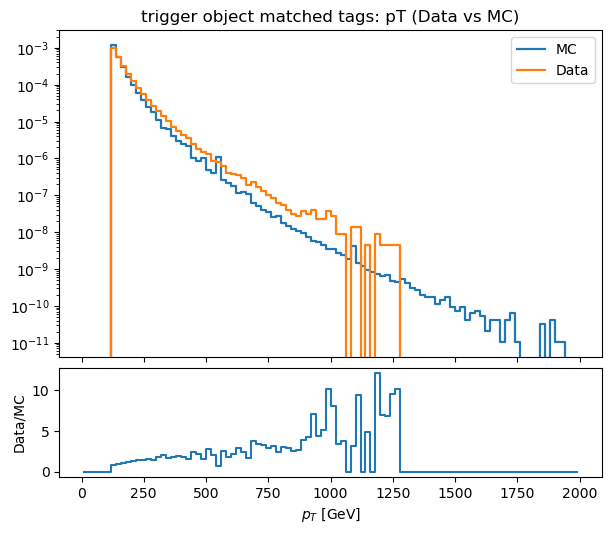

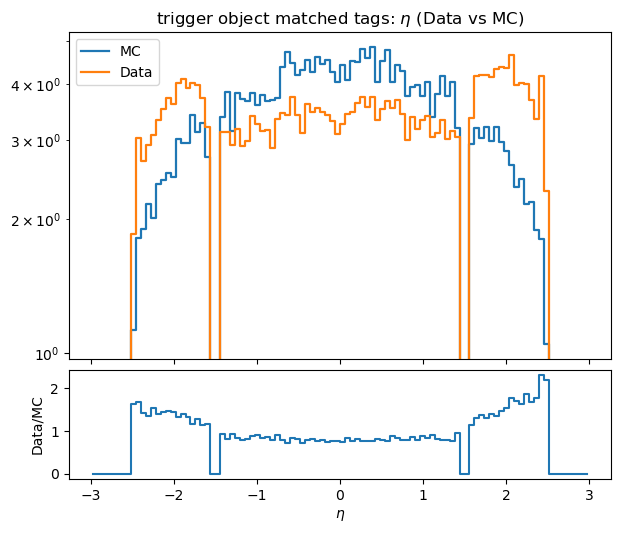

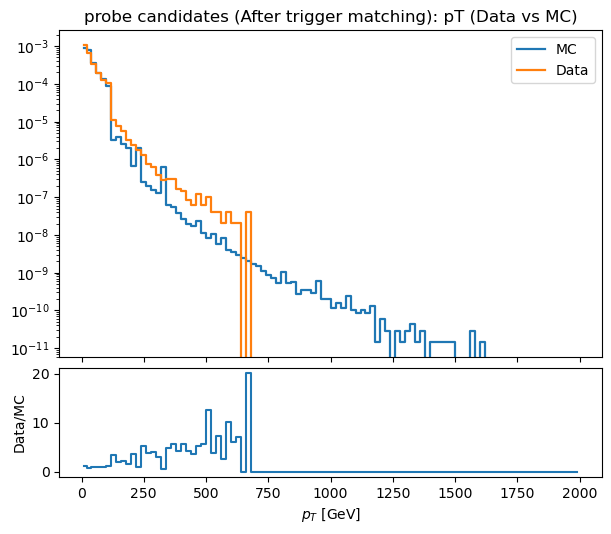

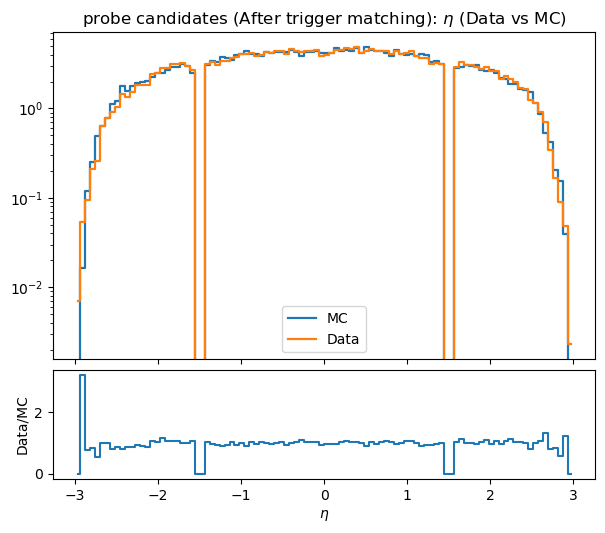

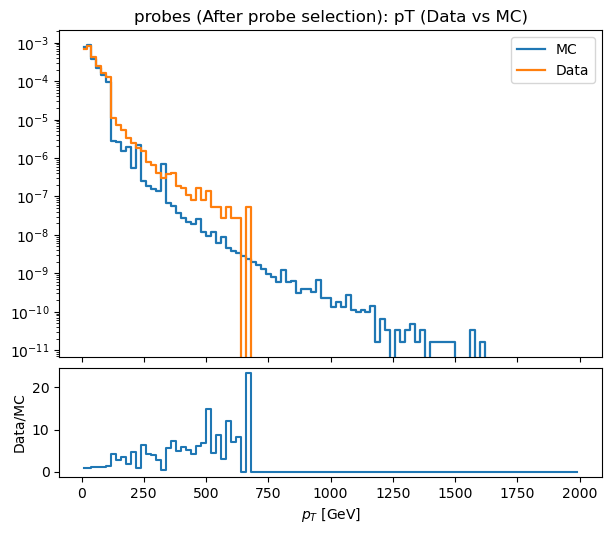

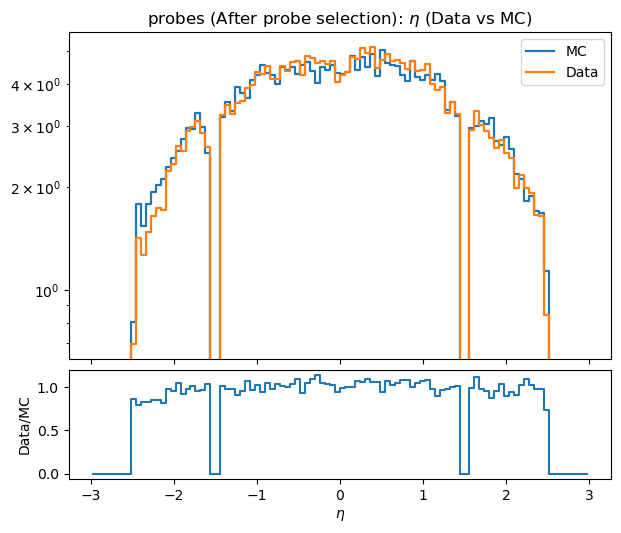

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from hist import Hist

def add_hists(*hs: Hist) -> Hist:
    h = hs[0].copy()
    for x in hs[1:]:
        h += x
    return h

def mc_sum(key: str):
    return add_hists(ds_mc_40_100[key], ds_mc_100_200[key],
                     ds_mc_200_400[key], ds_mc_400_600[key],
                     ds_mc_600[key])

def dt_get(key: str):
    return ds_data[key]

def plot_data_mc_with_ratio(h_data: Hist, h_mc: Hist, xlabel: str, title: str, ylim=None, logy=False, ylabel=None, density=False):
    centers = h_mc.axes[0].centers
    d_vals  = h_data.values()
    m_vals  = h_mc.values()
    edges   = h_mc.axes[0].edges
    widths  = np.diff(edges)


    fig = plt.figure(figsize=(7, 5.8))
    gs  = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)
    ax  = fig.add_subplot(gs[0])
    rax = fig.add_subplot(gs[1], sharex=ax)

    if density:
        m_area = np.sum(m_vals * widths)
        d_area = np.sum(d_vals * widths)
        m_vals = m_vals / (m_area * widths)
        d_vals = d_vals / (d_area * widths)

    ratio = np.divide(d_vals, m_vals, out=np.zeros_like(d_vals, dtype=float), where=m_vals>0)
    ax.step(centers, m_vals, where="mid", linewidth=1.6, label="MC")
    ax.step(centers, d_vals, where="mid", linewidth=1.6, label="Data")

    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    if logy==True:
        ax.set_yscale("log")
    if ylabel==None:
        ax.set_ylabel("Events")
    else:
        ax.set_ylabel(ylabel)
        
    ax.set_title(title)
    ax.legend()

    rax.step(centers, ratio, where="mid")
    rax.set_ylabel("Data/MC")
    rax.set_xlabel(xlabel)

    plt.setp(ax.get_xticklabels(), visible=False)
    plt.tight_layout()
    plt.show()



stages = {
    "event_check": ("h_event_check_pt", "h_event_check_eta", "all events"),
    "ele2_check": ("h_ele2_check_pt", "h_ele2_check_eta", "event-level cut"),
    "ele2_after_eta_trasition_cut_check": ("h_ele2_after_eta_trasition_cut_check_pt","h_ele2_after_eta_trasition_cut_check_eta","after the eta trasition cut"),
    "e_tag_check": ("h_e_tag_check_pt", "h_e_tag_check_eta", "after tag selection"),
    "not_tag_e_tagcut_check": ("h_not_tag_e_tagcut_check_pt", "h_not_tag_e_tagcut_check_eta", "non-tags (failed tag selection cuts)"),
    "e_tag_matched_check": ("h_e_tag_matched_check_pt", "h_e_tag_matched_check_eta", "trigger object matched tags"),
    "probe_cand_check": ("h_probe_cand_check_pt", "h_probe_cand_check_eta", "probe candidates (After trigger matching)"),
    "probe_check": ("h_probe_check_pt", "h_probe_check_eta", "probes (After probe selection)"),
}

for stg, (kpt, keta, nice) in stages.items():
    h_mc_pt  = mc_sum(kpt)
    h_dt_pt  = dt_get(kpt)
    h_mc_eta = mc_sum(keta)
    h_dt_eta = dt_get(keta)

    plot_data_mc_with_ratio(
        h_dt_pt, h_mc_pt,
        xlabel=r"$p_T$ [GeV]",
        title=f"{nice}: pT (Data vs MC)",
        ylim=None,
        logy=True,
        ylabel= "",
        density=True
        
    )

    plot_data_mc_with_ratio(
        h_dt_eta, h_mc_eta,
        xlabel=r"$\eta$",
        title=f"{nice}: $\eta$ (Data vs MC)",
        ylim=None,
        logy=True,
        ylabel= "",
        density=True
    )



'''
1st plot:
After event level cut: apply trigger selection: `HLT_Ele115_CaloIdVT_GsfTrkIdT` OR `HLT_Photon200`
Electron.mvaNoIso_WP90 > 0 AND nElectron >= 2
ele2_check 

2nd plot:
After the transition religion cut
ECAL transition region: 1.44 < |η| < 1.57 that should be vetoed
ele2_after_eta_trasition_cut_check

3rd/4th plot:
After general tag selection: pt > 120 GeV AND ak.abs(eta) < 2.5  AND Electron.dz < 0.1 (0.2) cm for Barrel (endcap).
        # barrel ( |eta supercluster| <= 1.479)
        # endcap ( |eta supercluster| > 1.479)
        # Tight MVA ID: Electron.mvaNoIso_WP80 > 0
e_tag_check
not_tag_e_tagcut_check

5th/6th plot
After trigger matching 
#(events.TrigObj.id == 11) & ((events.TrigObj.filterBits & (1 << 12)) != 0 OR (events.TrigObj.filterBits & (1 << 14)) != 0) dr<0.1
e_tag_matched_check
probe_cand_check

7th plot
After probe selection:
probe e: pt > 10 GeV AND ak.abs(eta) < 2.5
probe_check
'''


/tmp/ipykernel_27010/2417028480.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


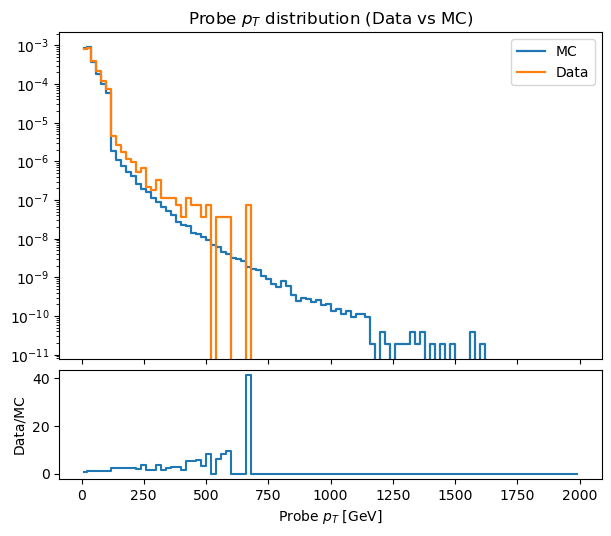

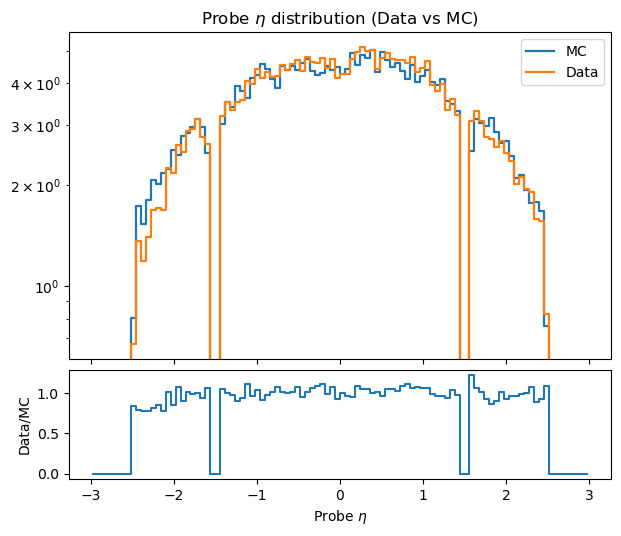

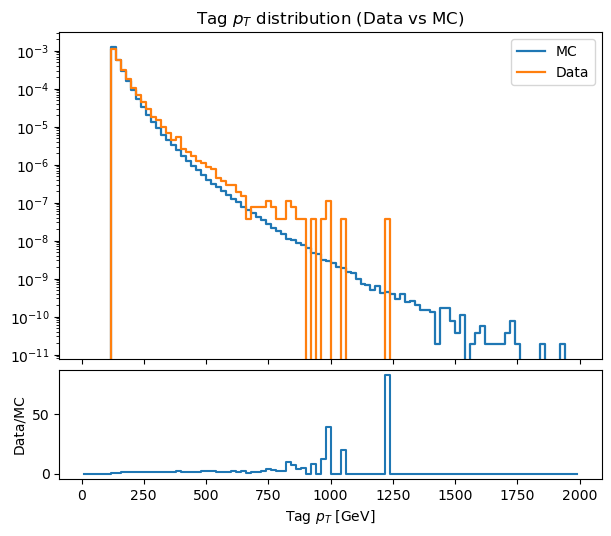

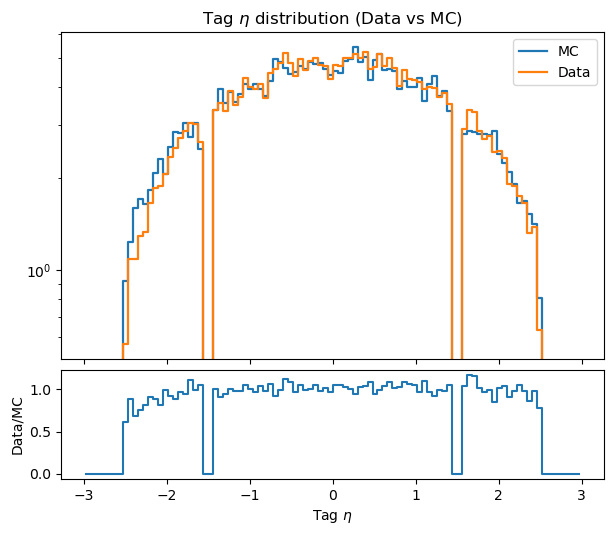

In [34]:
mc_probe_pt  = add_hists(ds_mc_40_100["h_probe_pt"],  ds_mc_100_200["h_probe_pt"],
                         ds_mc_200_400["h_probe_pt"], ds_mc_400_600["h_probe_pt"],
                         ds_mc_600["h_probe_pt"])
mc_probe_eta = add_hists(ds_mc_40_100["h_probe_eta"], ds_mc_100_200["h_probe_eta"],
                         ds_mc_200_400["h_probe_eta"],ds_mc_400_600["h_probe_eta"],
                         ds_mc_600["h_probe_eta"])

data_probe_pt  = ds_data["h_probe_pt"]
data_probe_eta = ds_data["h_probe_eta"]


mc_tag_pt  = add_hists(ds_mc_40_100["h_tag_pt"],  ds_mc_100_200["h_tag_pt"],
                        ds_mc_200_400["h_tag_pt"], ds_mc_400_600["h_tag_pt"],
                        ds_mc_600["h_tag_pt"])
mc_tag_eta = add_hists(ds_mc_40_100["h_tag_eta"], ds_mc_100_200["h_tag_eta"],
                        ds_mc_200_400["h_tag_eta"],ds_mc_400_600["h_tag_eta"],
                        ds_mc_600["h_tag_eta"])
data_tag_pt  = ds_data["h_tag_pt"]
data_tag_eta = ds_data["h_tag_eta"]




plot_data_mc_with_ratio(
    data_probe_pt, mc_probe_pt,
    xlabel=r"Probe $p_T$ [GeV]",
    title=r"Probe $p_T$ distribution (Data vs MC)",
    ylim=None,
    logy=True,
    ylabel= "",
    density=True
)

plot_data_mc_with_ratio(
    data_probe_eta, mc_probe_eta,
    xlabel=r"Probe $\eta$",
    title=r"Probe $\eta$ distribution (Data vs MC)",
    ylim=None,
    logy=True,
    ylabel= "",
    density=True
)


plot_data_mc_with_ratio(
    data_tag_pt, mc_tag_pt,
    xlabel=r"Tag $p_T$ [GeV]",
    title=r"Tag $p_T$ distribution (Data vs MC)",
    ylim=None,
    logy=True,
    ylabel= "",
    density=True
)
plot_data_mc_with_ratio(
    data_tag_eta, mc_tag_eta,
    xlabel=r"Tag $\eta$",
    title=r"Tag $\eta$ distribution (Data vs MC)",
    ylim=None,
    logy=True,
    ylabel= "",
    density=True
)


/tmp/ipykernel_27010/2417028480.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


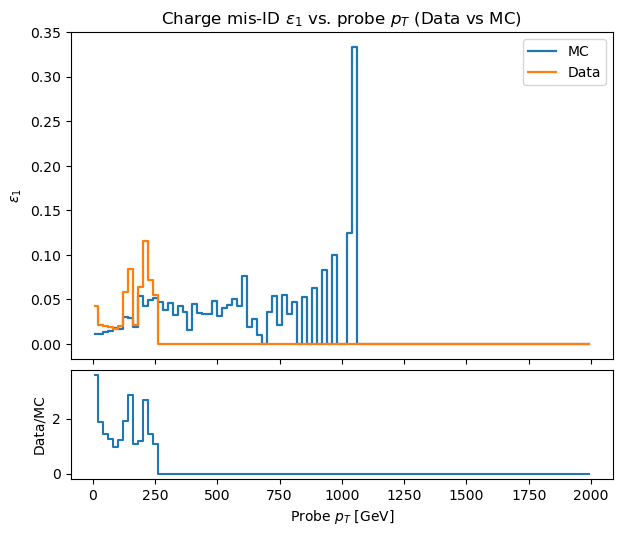

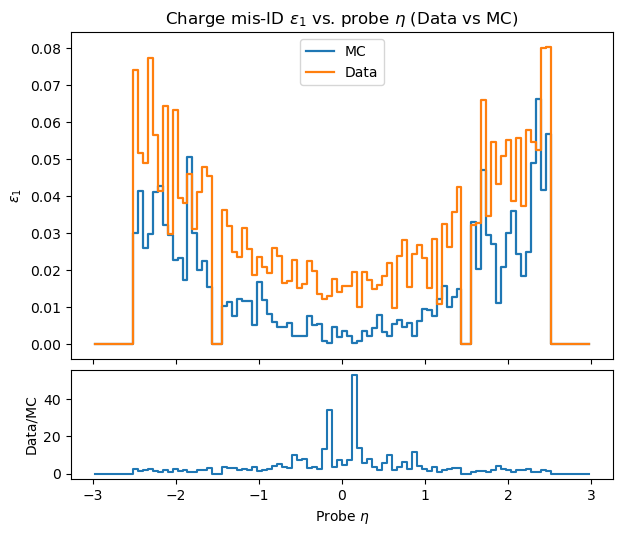

In [35]:
# epsilon 1 vs. pT/eta
mc_same_pt = add_hists(ds_mc_40_100["h_same_pt"],  ds_mc_100_200["h_same_pt"],
                         ds_mc_200_400["h_same_pt"], ds_mc_400_600["h_same_pt"],
                         ds_mc_600["h_same_pt"])
mc_tot_pt  = add_hists(ds_mc_40_100["h_probe_pt"],  ds_mc_100_200["h_probe_pt"],
                         ds_mc_200_400["h_probe_pt"], ds_mc_400_600["h_probe_pt"],
                         ds_mc_600["h_probe_pt"])
data_same_pt = ds_data["h_same_pt"]
data_tot_pt  = ds_data["h_probe_pt"]

mc_same_vals_pt = mc_same_pt.values()
mc_tot_vals_pt  = mc_tot_pt.values()
eps1_mc_pt_vals = np.divide(mc_same_vals_pt, mc_tot_vals_pt,
                            out=np.zeros_like(mc_same_vals_pt, float),
                            where=mc_tot_vals_pt > 0)

data_same_vals_pt = data_same_pt.values()
data_tot_vals_pt  = data_tot_pt.values()
eps1_data_pt_vals = np.divide(data_same_vals_pt, data_tot_vals_pt,
                              out=np.zeros_like(data_same_vals_pt, float),
                              where=data_tot_vals_pt > 0)

ax_pt = mc_same_pt.axes[0]
eps1_mc_pt_hist   = Hist(ax_pt, storage=storage.Weight())
eps1_data_pt_hist = Hist(ax_pt, storage=storage.Weight())

v_mc_pt = eps1_mc_pt_hist.view()
v_mc_pt.value[...]    = eps1_mc_pt_vals
v_mc_pt.variance[...] = 0.0

v_data_pt = eps1_data_pt_hist.view()
v_data_pt.value[...]    = eps1_data_pt_vals
v_data_pt.variance[...] = 0.0

plot_data_mc_with_ratio(
    eps1_data_pt_hist, eps1_mc_pt_hist,
    xlabel=r"Probe $p_T$ [GeV]",
    title=r"Charge mis-ID $\epsilon_1$ vs. probe $p_T$ (Data vs MC)",
    ylim=None,
    ylabel=r"$\epsilon_1$"
)



mc_same_eta = add_hists(ds_mc_40_100["h_same_eta"],  ds_mc_100_200["h_same_eta"],
                         ds_mc_200_400["h_same_eta"], ds_mc_400_600["h_same_eta"],
                         ds_mc_600["h_same_eta"])
mc_tot_eta = add_hists(ds_mc_40_100["h_probe_eta"],  ds_mc_100_200["h_probe_eta"],
                         ds_mc_200_400["h_probe_eta"], ds_mc_400_600["h_probe_eta"],
                         ds_mc_600["h_probe_eta"])
data_same_eta = ds_data["h_same_eta"]
data_tot_eta  = ds_data["h_probe_eta"]

mc_same_vals_eta = mc_same_eta.values()
mc_tot_vals_eta  = mc_tot_eta.values()
eps1_mc_eta_vals = np.divide(mc_same_vals_eta, mc_tot_vals_eta,
                             out=np.zeros_like(mc_same_vals_eta, float),
                             where=mc_tot_vals_eta > 0)

data_same_vals_eta = data_same_eta.values()
data_tot_vals_eta  = data_tot_eta.values()
eps1_data_eta_vals = np.divide(data_same_vals_eta, data_tot_vals_eta,
                               out=np.zeros_like(data_same_vals_eta, float),
                               where=data_tot_vals_eta > 0)

ax_eta = mc_same_eta.axes[0]
eps1_mc_eta_hist   = Hist(ax_eta, storage=storage.Weight())
eps1_data_eta_hist = Hist(ax_eta, storage=storage.Weight())

v_mc_eta = eps1_mc_eta_hist.view()
v_mc_eta.value[...]    = eps1_mc_eta_vals
v_mc_eta.variance[...] = 0.0

v_data_eta = eps1_data_eta_hist.view()
v_data_eta.value[...]    = eps1_data_eta_vals
v_data_eta.variance[...] = 0.0

plot_data_mc_with_ratio(
    eps1_data_eta_hist, eps1_mc_eta_hist,
    xlabel=r"Probe $\eta$",
    title=r"Charge mis-ID $\epsilon_1$ vs. probe $\eta$ (Data vs MC)",
    ylim=None,
    ylabel=r"$\epsilon_1$"
)



/tmp/ipykernel_27010/2417028480.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


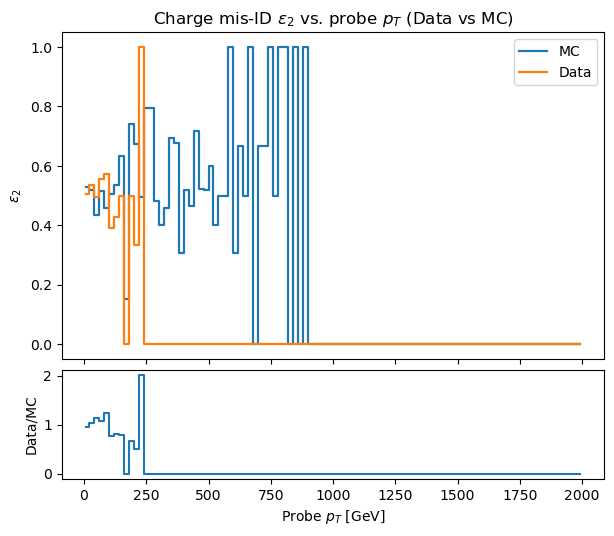

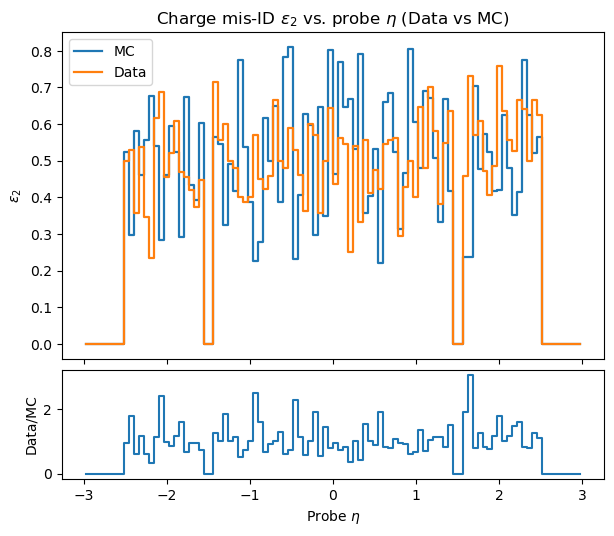

In [36]:
# epsilon 2 vs. pT/eta
mc_pp_pt   = add_hists(ds_mc_40_100["h_pp_pt"],   ds_mc_100_200["h_pp_pt"],
                       ds_mc_200_400["h_pp_pt"],  ds_mc_400_600["h_pp_pt"],
                       ds_mc_600["h_pp_pt"])


data_pp_pt   = ds_data["h_pp_pt"]

mc_eps2_pt   = np.divide(mc_pp_pt.values(),   mc_same_pt.values(),
                         out=np.zeros_like(mc_pp_pt.values(), dtype=float),
                         where=mc_same_pt.values() > 0)
data_eps2_pt = np.divide(data_pp_pt.values(), data_same_pt.values(),
                         out=np.zeros_like(data_pp_pt.values(), dtype=float),
                         where=data_same_pt.values() > 0)

ax_pt = mc_pp_pt.axes[0]
h_eps2_mc_pt   = Hist(ax_pt, storage=storage.Weight())
h_eps2_data_pt = Hist(ax_pt, storage=storage.Weight())
v_mc_pt = h_eps2_mc_pt.view()
v_mc_pt.value[:] = mc_eps2_pt
v_mc_pt.variance[:] = 0.0
v_dt_pt = h_eps2_data_pt.view()
v_dt_pt.value[:] = data_eps2_pt
v_dt_pt.variance[:] = 0.0

plot_data_mc_with_ratio(
    h_eps2_data_pt, h_eps2_mc_pt,
    xlabel=r"Probe $p_T$ [GeV]",
    title=r"Charge mis-ID $\epsilon_2$ vs. probe $p_T$ (Data vs MC)",
    ylim=None,
    ylabel=r"$\epsilon_2$"
)


mc_pp_eta   = add_hists(ds_mc_40_100["h_pp_eta"],   ds_mc_100_200["h_pp_eta"],
                        ds_mc_200_400["h_pp_eta"],  ds_mc_400_600["h_pp_eta"],
                        ds_mc_600["h_pp_eta"])

data_pp_eta   = ds_data["h_pp_eta"]

mc_eps2_eta   = np.divide(mc_pp_eta.values(),   mc_same_eta.values(),
                          out=np.zeros_like(mc_pp_eta.values(), dtype=float),
                          where=mc_same_eta.values() > 0)
data_eps2_eta = np.divide(data_pp_eta.values(), data_same_eta.values(),
                          out=np.zeros_like(data_pp_eta.values(), dtype=float),
                          where=data_same_eta.values() > 0)

ax_eta = mc_pp_eta.axes[0]
h_eps2_mc_eta   = Hist(ax_eta, storage=storage.Weight())
h_eps2_data_eta = Hist(ax_eta, storage=storage.Weight())
v_mc_eta = h_eps2_mc_eta.view()
v_mc_eta.value[:] = mc_eps2_eta
v_mc_eta.variance[:] = 0.0
v_dt_eta = h_eps2_data_eta.view()
v_dt_eta.value[:] = data_eps2_eta
v_dt_eta.variance[:] = 0.0

plot_data_mc_with_ratio(
    h_eps2_data_eta, h_eps2_mc_eta,
    xlabel=r"Probe $\eta$",
    title=r"Charge mis-ID $\epsilon_2$ vs. probe $\eta$ (Data vs MC)",
    ylim=None,
    ylabel=r"$\epsilon_2$"
)


/tmp/ipykernel_27010/2417028480.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


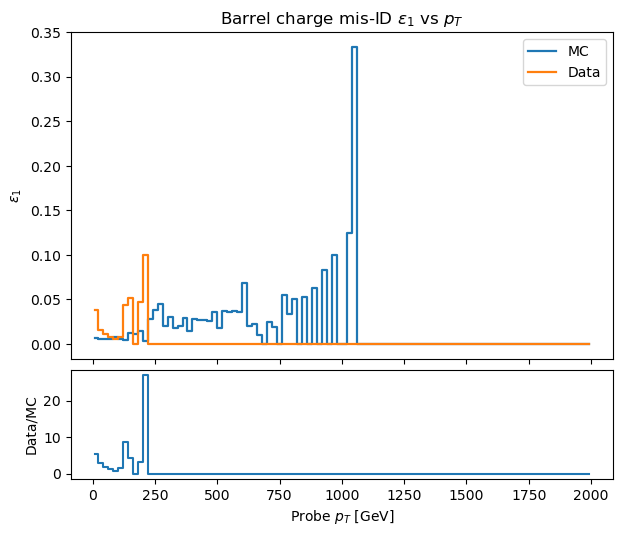

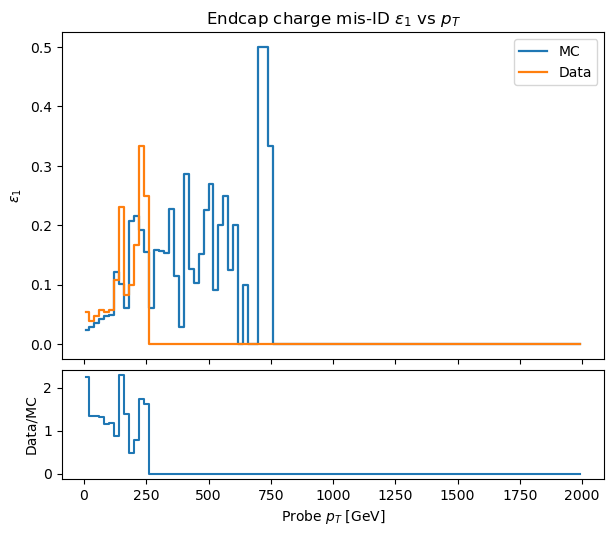

In [37]:
#separate barrel and end cap 
#epsion 1
mc_same_pt_barrel = add_hists(ds_mc_40_100["h_same_pt_barrel"],  ds_mc_100_200["h_same_pt_barrel"],
                              ds_mc_200_400["h_same_pt_barrel"], ds_mc_400_600["h_same_pt_barrel"],
                              ds_mc_600["h_same_pt_barrel"])
mc_tot_pt_barrel  = add_hists(ds_mc_40_100["h_tot_pt_barrel"],   ds_mc_100_200["h_tot_pt_barrel"],
                              ds_mc_200_400["h_tot_pt_barrel"],  ds_mc_400_600["h_tot_pt_barrel"],
                              ds_mc_600["h_tot_pt_barrel"])

mc_same_pt_endcap = add_hists(ds_mc_40_100["h_same_pt_endcap"],  ds_mc_100_200["h_same_pt_endcap"],
                              ds_mc_200_400["h_same_pt_endcap"], ds_mc_400_600["h_same_pt_endcap"],
                              ds_mc_600["h_same_pt_endcap"])
mc_tot_pt_endcap  = add_hists(ds_mc_40_100["h_tot_pt_endcap"],   ds_mc_100_200["h_tot_pt_endcap"],
                              ds_mc_200_400["h_tot_pt_endcap"],  ds_mc_400_600["h_tot_pt_endcap"],
                              ds_mc_600["h_tot_pt_endcap"])

data_same_pt_barrel = ds_data["h_same_pt_barrel"]
data_tot_pt_barrel  = ds_data["h_tot_pt_barrel"]

data_same_pt_endcap = ds_data["h_same_pt_endcap"]
data_tot_pt_endcap  = ds_data["h_tot_pt_endcap"]

# epsilon 1 barrel
mc_eps1_barrel = np.divide(mc_same_pt_barrel.values(), mc_tot_pt_barrel.values(),
                           out=np.zeros_like(mc_same_pt_barrel.values(), dtype=float),
                           where=mc_tot_pt_barrel.values() > 0)
dt_eps1_barrel = np.divide(data_same_pt_barrel.values(), data_tot_pt_barrel.values(),
                           out=np.zeros_like(data_same_pt_barrel.values(), dtype=float),
                           where=data_tot_pt_barrel.values() > 0)

ax_pt_barrel = mc_same_pt_barrel.axes[0]
h_eps1_mc_barrel   = Hist(ax_pt_barrel, storage=storage.Weight())
h_eps1_data_barrel = Hist(ax_pt_barrel, storage=storage.Weight())
v_mc_b = h_eps1_mc_barrel.view()
v_mc_b.value[:] = mc_eps1_barrel
v_mc_b.variance[:] = 0.0
v_dt_b = h_eps1_data_barrel.view()
v_dt_b.value[:] = dt_eps1_barrel
v_dt_b.variance[:] = 0.0

plot_data_mc_with_ratio(
    h_eps1_data_barrel, h_eps1_mc_barrel,
    xlabel=r"Probe $p_T$ [GeV]",
    title=r"Barrel charge mis-ID $\epsilon_1$ vs $p_T$",
    ylim=None,
    ylabel=r"$\epsilon_1$"
)

# epsilon 1 endcap 
mc_eps1_endcap = np.divide(mc_same_pt_endcap.values(), mc_tot_pt_endcap.values(),
                           out=np.zeros_like(mc_same_pt_endcap.values(), dtype=float),
                           where=mc_tot_pt_endcap.values() > 0)
dt_eps1_endcap = np.divide(data_same_pt_endcap.values(), data_tot_pt_endcap.values(),
                           out=np.zeros_like(data_same_pt_endcap.values(), dtype=float),
                           where=data_tot_pt_endcap.values() > 0)

ax_pt_endcap = mc_same_pt_endcap.axes[0]
h_eps1_mc_endcap   = Hist(ax_pt_endcap, storage=storage.Weight())
h_eps1_data_endcap = Hist(ax_pt_endcap, storage=storage.Weight())
v_mc_e = h_eps1_mc_endcap.view()
v_mc_e.value[:] = mc_eps1_endcap
v_mc_e.variance[:] = 0.0
v_dt_e = h_eps1_data_endcap.view()
v_dt_e.value[:] = dt_eps1_endcap
v_dt_e.variance[:] = 0.0

plot_data_mc_with_ratio(
    h_eps1_data_endcap, h_eps1_mc_endcap,
    xlabel=r"Probe $p_T$ [GeV]",
    title=r"Endcap charge mis-ID $\epsilon_1$ vs $p_T$",
    ylim=None,
    ylabel=r"$\epsilon_1$"
)


/tmp/ipykernel_27010/2417028480.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


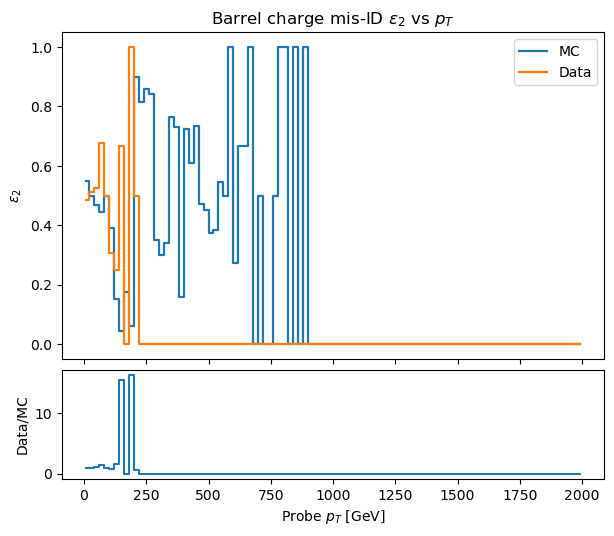

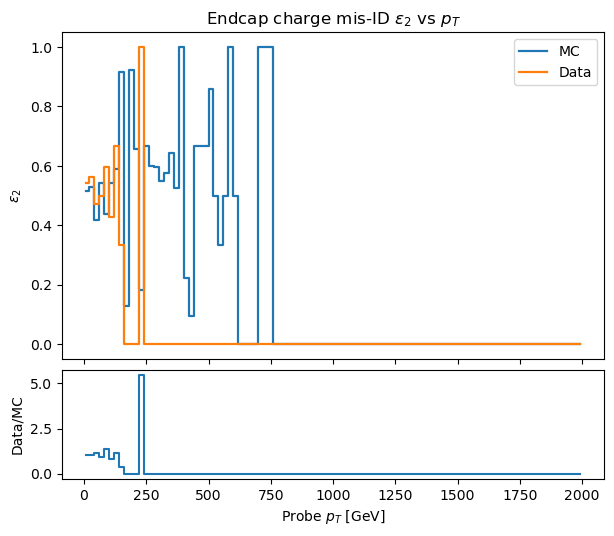

In [39]:
#separate barrel and end cap 
#epsion 2

mc_pp_pt_barrel   = add_hists(ds_mc_40_100["h_pp_pt_barrel"],   ds_mc_100_200["h_pp_pt_barrel"],
                              ds_mc_200_400["h_pp_pt_barrel"],  ds_mc_400_600["h_pp_pt_barrel"],
                              ds_mc_600["h_pp_pt_barrel"])

mc_pp_pt_endcap   = add_hists(ds_mc_40_100["h_pp_pt_endcap"],   ds_mc_100_200["h_pp_pt_endcap"],
                              ds_mc_200_400["h_pp_pt_endcap"],  ds_mc_400_600["h_pp_pt_endcap"],
                              ds_mc_600["h_pp_pt_endcap"])


data_pp_pt_barrel   = ds_data["h_pp_pt_barrel"]
data_pp_pt_endcap   = ds_data["h_pp_pt_endcap"]


# epsilon 2 barrel
mc_eps2_barrel = np.divide(
    mc_pp_pt_barrel.values(), mc_same_pt_barrel.values(),
    out=np.zeros_like(mc_pp_pt_barrel.values(), dtype=float),
    where=mc_same_pt_barrel.values() > 0
)
dt_eps2_barrel = np.divide(
    data_pp_pt_barrel.values(), data_same_pt_barrel.values(),
    out=np.zeros_like(data_pp_pt_barrel.values(), dtype=float),
    where=data_same_pt_barrel.values() > 0
)

ax_b = mc_same_pt_barrel.axes[0]
h_eps2_mc_barrel   = Hist(ax_b, storage=storage.Weight())
h_eps2_data_barrel = Hist(ax_b, storage=storage.Weight())
vb_mc = h_eps2_mc_barrel.view()
vb_mc.value[:] = mc_eps2_barrel
vb_mc.variance[:] = 0.0
vb_dt = h_eps2_data_barrel.view()
vb_dt.value[:] = dt_eps2_barrel
vb_dt.variance[:] = 0.0

plot_data_mc_with_ratio(
    h_eps2_data_barrel, h_eps2_mc_barrel,
    xlabel=r"Probe $p_T$ [GeV]",
    title=r"Barrel charge mis-ID $\epsilon_2$ vs $p_T$",
    ylim=None,
    ylabel=r"$\epsilon_2$"
)

# epsilon 2 endcap
mc_eps2_endcap = np.divide(
    mc_pp_pt_endcap.values(), mc_same_pt_endcap.values(),
    out=np.zeros_like(mc_pp_pt_endcap.values(), dtype=float),
    where=mc_same_pt_endcap.values() > 0
)
dt_eps2_endcap = np.divide(
    data_pp_pt_endcap.values(), data_same_pt_endcap.values(),
    out=np.zeros_like(data_pp_pt_endcap.values(), dtype=float),
    where=data_same_pt_endcap.values() > 0
)

ax_e = mc_same_pt_endcap.axes[0]
h_eps2_mc_endcap   = Hist(ax_e, storage=storage.Weight())
h_eps2_data_endcap = Hist(ax_e, storage=storage.Weight())
ve_mc = h_eps2_mc_endcap.view()
ve_mc.value[:] = mc_eps2_endcap
ve_mc.variance[:] = 0.0
ve_dt = h_eps2_data_endcap.view()
ve_dt.value[:] = dt_eps2_endcap
ve_dt.variance[:] = 0.0

plot_data_mc_with_ratio(
    h_eps2_data_endcap, h_eps2_mc_endcap,
    xlabel=r"Probe $p_T$ [GeV]",
    title=r"Endcap charge mis-ID $\epsilon_2$ vs $p_T$",
    ylim=None,
    ylabel=r"$\epsilon_2$"
)


In [45]:
#n0_mc = ds_mc["n0"]
#n_keep_mc = int(ak.to_numpy(ds_mc["n_keep"]).item())
#print(f"MC kept {n_keep_mc}/{n0_mc} events")

n0_data = ds_data["n0"]
print(n0_data)
n_keep_data = int(ak.to_numpy(ds_data["n_keep"]).item())
print(f"data lumimask kept {n_keep_data}/{n0_data} events")

data_n_pp = int(ds_data["num_pp"])
data_n_mm = int(ds_data["num_mm"])
data_n_pm = int(ds_data["num_pm"])

print("for data")
print("++ rows:", data_n_pp)
print("-- rows:", data_n_mm)
print("+- rows:", data_n_pm)


mc_keys = ["DY_40_100","DY_100_200","DY_200_400","DY_400_600","DY_600"]

mc_pp_total = 0
mc_mm_total = 0
mc_pm_total = 0

print("for MC (unweighted)")
for k in mc_keys:
    ds = out[k]
    n_pp = int(ds["num_pp"])
    n_mm = int(ds["num_mm"])
    n_pm = int(ds["num_pm"])
    mc_pp_total += n_pp
    mc_mm_total += n_mm
    mc_pm_total += n_pm
    print(f"[{k}] ++: {n_pp:>1}  --: {n_mm:>1}  +- : {n_pm:>1}")

print("MC total")
print("++ rows:", mc_pp_total)
print("-- rows:", mc_mm_total)
print("+- rows:", mc_pm_total)


561875400
data lumimask kept 556473494/561875400 events
for data
++ rows: 949
-- rows: 898
+- rows: 65041
for MC (unweighted)
[DY_40_100] ++: 1  --: 1  +- : 78
[DY_100_200] ++: 195  --: 193  +- : 33674
[DY_200_400] ++: 894  --: 859  +- : 112924
[DY_400_600] ++: 1071  --: 990  +- : 101415
[DY_600] ++: 881  --: 762  +- : 75281
MC total
++ rows: 3042
-- rows: 2805
+- rows: 323372
